In [1]:
import os
import flexynesis
import torch
import numpy as np
import seaborn as sns
import pandas as pd
import random
import lightning as pl

Seed set to 42


# Finding Survival Markers in Lower Grade Glioma (LGG) and Glioblastoma Multiforme (GBM)seed

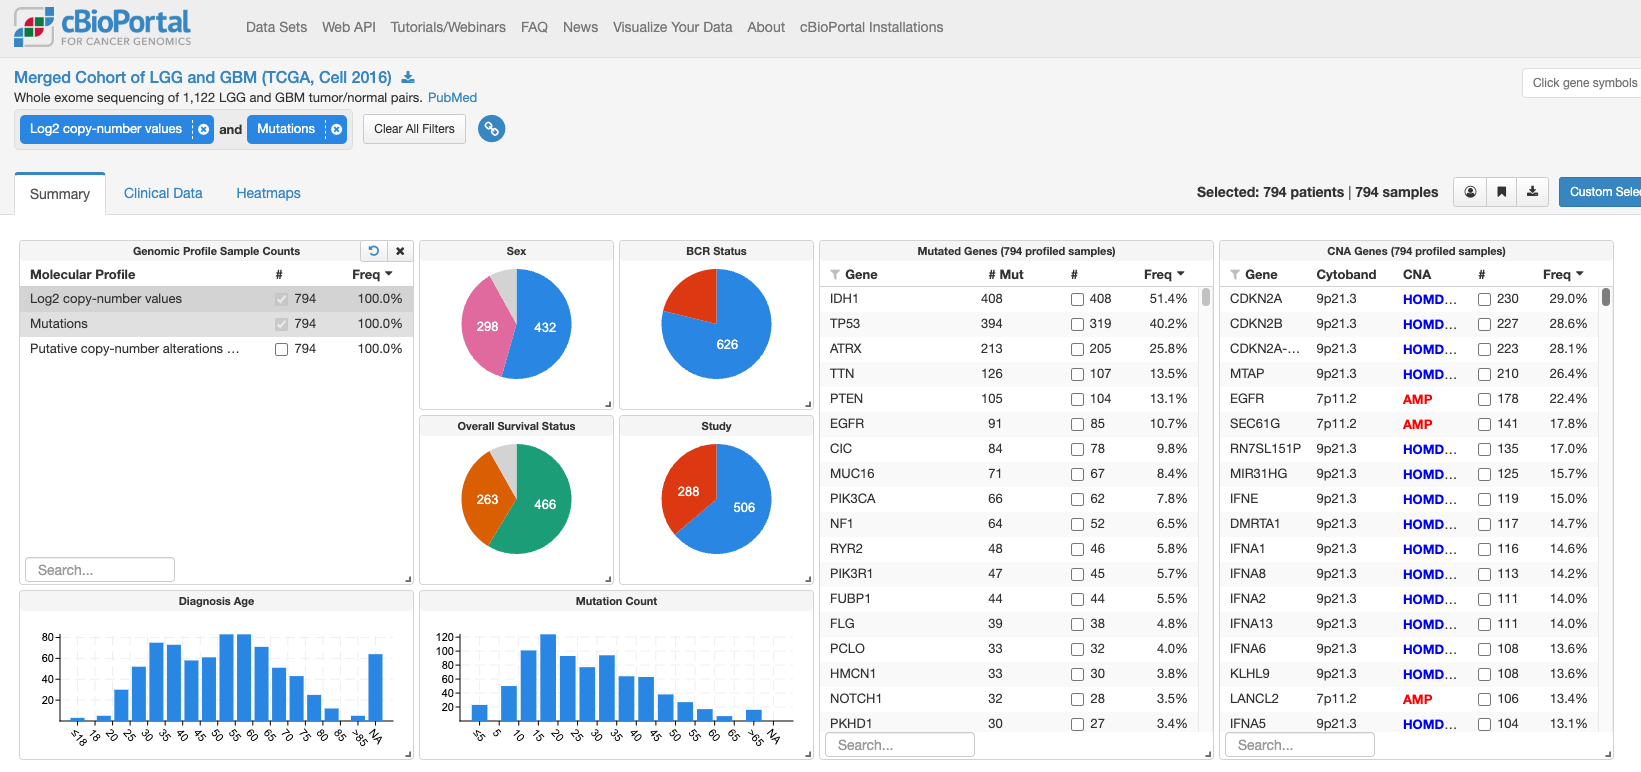

Here, we demonstrate the capabilities of `flexynesis` on a multi-omic dataset of 506 Brain Lower Grade Glioma (LGG) and 288 Glioblastoma Multiforme (GBM) samples with matching mutation and copy number alteration data downloaded from the [cbioportal](https://www.cbioportal.org/study/summary?id=lgggbm_tcga_pub). The data was split into `train` (70% of the samples) and `test` (30% of the samples) data folders. The data files were processed to follow the same nomenclature. 

- `cna.csv` contains "copy number alteration" data
- `mut.csv` contains "mutation" data, which is a binary matrix of genes versus samples. 
- `clin.csv` contains "clinical/sample metatada", which is a table of clinical parameters such as age, sex, disease type, histological diagnosis, and overall survival time and status. 

## Data Download

The data can be downloaded as follows:

In [2]:
if not os.path.exists("lgggbm_tcga_pub_processed"):
    !wget -O lgggbm_tcga_pub_processed.tgz "https://bimsbstatic.mdc-berlin.de/akalin/buyar/flexynesis-benchmark-datasets/lgggbm_tcga_pub_processed.tgz" && tar -xzvf lgggbm_tcga_pub_processed.tgz

## Importing Train and Test Datasets

We import train and test datasets including mutations and copy number alterations. We rank genes by Laplacian Scores and pick top 10% of the genes, while removing highly redundant genes with a correlation score threshold of 0.8 and a variance threshold of 50%. By setting `concatenate` to `False`, we will be doing an `intermediate` fusion of omic layers. 

In [3]:
data_importer = flexynesis.DataImporter(path ='lgggbm_tcga_pub_processed', 
                                        data_types = ['mut', 'cna'], log_transform=False, 
                                        concatenate=False, top_percentile=10, min_features=1000, correlation_threshold=0.8, 
                                       variance_threshold=0.5)
train_dataset, test_dataset = data_importer.import_data()


[INFO] ================= Importing Data =================
[INFO] Validating data folders...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing lgggbm_tcga_pub_processed/train/clin.csv...
[INFO] Importing lgggbm_tcga_pub_processed/train/mut.csv...
[INFO] Importing lgggbm_tcga_pub_processed/train/cna.csv...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing lgggbm_tcga_pub_processed/test/clin.csv...
[INFO] Importing lgggbm_tcga_pub_processed/test/mut.csv...
[INFO] Importing lgggbm_tcga_pub_processed/test/cna.csv...

[INFO] ----------------- Checking for problems with the input data ----------------- 
[INFO] Data structure is valid with no errors or warnings.

[INFO] ----------------- Processing Data (train) ----------------- 

[INFO] ----------------- Cleaning Up Data ----------------- 

[INFO] working on layer:  mut
[INFO] Number of NA values:  0
[INFO] DataFrame mut - Removed 5561 features.

[INFO] working on layer:  cna
[INFO] Number of

Filtering redundant features: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 17541.61it/s]


[INFO] Implementing feature selection using laplacian score for layer: cna with  12371 features  and  556  samples 


Filtering redundant features: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1237/1237 [00:00<00:00, 117311.91it/s]



[INFO] ----------------- Processing Data (test) ----------------- 

[INFO] ----------------- Cleaning Up Data ----------------- 

[INFO] working on layer:  mut
[INFO] Number of NA values:  0
[INFO] DataFrame mut - Removed 5627 features.

[INFO] working on layer:  cna
[INFO] Number of NA values:  0
[INFO] DataFrame cna - Removed 12382 features.
[INFO] DataFrame mut - Removed 0 samples (0.00%).
[INFO] DataFrame cna - Removed 0 samples (0.00%).

[INFO] ----------------- Harmonizing Data Sets ----------------- 

[INFO] ----------------- Finished Harmonizing ----------------- 

[INFO] ----------------- Normalizing Data ----------------- 

[INFO] ----------------- Normalizing Data ----------------- 
[INFO] Training Data Stats:  {'feature_count in: mut': 319, 'feature_count in: cna': 1237, 'sample_count': 556}
[INFO] Test Data Stats:  {'feature_count in: mut': 319, 'feature_count in: cna': 1237, 'sample_count': 238}
[INFO] Merging Feature Logs...
[INFO] Data import successful.


## 1. Exploratory Data Analysis 

Before building any machine learning models on the data, it is important to first familiarize yourself with the data you are working with. 
It is important to know the available data matrices, their sizes/shapes, available clinical variables and how they are distributed. 

Below you are asked to do simple explorations of the available data. 

## 1.1 Print the shapes of the available data matrices 

- How many features and samples are available per data type in train/test datasets? 

In [5]:
train_dataset.dat, test_dataset.dat

({'mut': tensor([[ 0.9822,  1.7075, -0.1721,  ..., -0.0424, -0.0424, -0.0424],
          [-1.0182, -0.5857, -0.1721,  ..., -0.0424, -0.0424, -0.0424],
          [ 0.9822, -0.5857, -0.1721,  ..., -0.0424, -0.0424, -0.0424],
          ...,
          [-1.0182, -0.5857, -0.1721,  ..., -0.0424, -0.0424, -0.0424],
          [ 0.9822,  1.7075, -0.1721,  ..., -0.0424, -0.0424, -0.0424],
          [-1.0182, -0.5857, -0.1721,  ..., -0.0424, -0.0424, -0.0424]]),
  'cna': tensor([[-0.1094, -0.6134, -0.7265,  ...,  0.3059, -0.7503, -0.7503],
          [-0.2568, -0.7563, -0.8625,  ...,  0.4102, -0.8840, -0.8840],
          [-0.2647, -0.7437, -0.8489,  ..., -1.7993, -0.8885, -0.8885],
          ...,
          [ 0.3430,  1.8009,  1.8774,  ...,  0.5255,  1.8112,  1.8112],
          [-0.2173, -0.6974, -0.8172,  ...,  0.3581, -0.8394, -0.8394],
          [-0.2436,  1.1411,  1.1930,  ...,  0.4898,  1.1379,  1.1379]])},
 {'mut': tensor([[-1.0182, -0.5857, -0.1721,  ..., -0.0424, -0.0424, -0.0424],
        

In [6]:
train_dataset.dat['mut'].shape, train_dataset.dat['cna'].shape

(torch.Size([556, 319]), torch.Size([556, 1237]))

In [7]:
test_dataset.dat['mut'].shape, test_dataset.dat['cna'].shape

(torch.Size([238, 319]), torch.Size([238, 1237]))

In [8]:
train_dataset.samples[1:20], train_dataset.features

(['TCGA-26-5134',
  'TCGA-FG-A710',
  'TCGA-14-0740',
  'TCGA-CS-5397',
  'TCGA-HT-7602',
  'TCGA-DU-7006',
  'TCGA-DU-8165',
  'TCGA-S9-A6WO',
  'TCGA-QH-A65R',
  'TCGA-19-2629',
  'TCGA-DU-A76R',
  'TCGA-DU-8163',
  'TCGA-DU-8167',
  'TCGA-HT-A4DV',
  'TCGA-DU-A5TT',
  'TCGA-06-0171',
  'TCGA-HT-8109',
  'TCGA-FG-7643',
  'TCGA-06-0645'],
 {'mut': Index(['IDH1', 'ATRX', 'RELN', 'IDH2', 'PIK3CA', 'EGFR', 'TP53', 'TBC1D9',
         'COL6A3', 'TEKT4',
         ...
         'C15orf39', 'ZBTB34', 'DAAM1', 'INTS7', 'DIRC2', 'ZNF571', 'NEURL1',
         'NYAP2', 'CD300LD-AS1', 'ENPP1'],
        dtype='object', length=319),
  'cna': Index(['SLC30A8', 'ZNF273', 'CLEC5A', 'AGL', 'KCNA5', 'MIR603', 'SNTB1',
         'MRPL13', 'MTBP', 'SNORA72|ENSG00000252158.1',
         ...
         'CAV1', 'FZD1', 'BCAP29', 'MNX1', 'ADAM22', 'LRP8', 'NOM1', 'RN7SL290P',
         'snoU13|ENSG00000239044.1', 'CPA1'],
        dtype='object', length=1237)})

In [9]:
train_dataset.samples[1:20], train_dataset.features

(['TCGA-26-5134',
  'TCGA-FG-A710',
  'TCGA-14-0740',
  'TCGA-CS-5397',
  'TCGA-HT-7602',
  'TCGA-DU-7006',
  'TCGA-DU-8165',
  'TCGA-S9-A6WO',
  'TCGA-QH-A65R',
  'TCGA-19-2629',
  'TCGA-DU-A76R',
  'TCGA-DU-8163',
  'TCGA-DU-8167',
  'TCGA-HT-A4DV',
  'TCGA-DU-A5TT',
  'TCGA-06-0171',
  'TCGA-HT-8109',
  'TCGA-FG-7643',
  'TCGA-06-0645'],
 {'mut': Index(['IDH1', 'ATRX', 'RELN', 'IDH2', 'PIK3CA', 'EGFR', 'TP53', 'TBC1D9',
         'COL6A3', 'TEKT4',
         ...
         'C15orf39', 'ZBTB34', 'DAAM1', 'INTS7', 'DIRC2', 'ZNF571', 'NEURL1',
         'NYAP2', 'CD300LD-AS1', 'ENPP1'],
        dtype='object', length=319),
  'cna': Index(['SLC30A8', 'ZNF273', 'CLEC5A', 'AGL', 'KCNA5', 'MIR603', 'SNTB1',
         'MRPL13', 'MTBP', 'SNORA72|ENSG00000252158.1',
         ...
         'CAV1', 'FZD1', 'BCAP29', 'MNX1', 'ADAM22', 'LRP8', 'NOM1', 'RN7SL290P',
         'snoU13|ENSG00000239044.1', 'CPA1'],
        dtype='object', length=1237)})

## 1.2 Explore sample annotations 

- What are the available clinical variables? Are they available in both train and test datasets? (See <dataset>.ann)  

In [10]:
train_dataset.ann, test_dataset.ann

({'AGE': tensor([nan, 74., 50., 70., 54., 21., 60., 60., 29., 38., 60., 51., 29., 69.,
          51., 70., 65., 64., 49., 55., 49., 34., 36., 85., 33., 64., 67., 32.,
          70., 29., 52., 54., 58., 54., 58., 74., 69., 60., 65., 21., 47., 30.,
          nan, 46., 37., 47., nan, 41., 63., 45., 63., 67., 27., 39., 81., 60.,
          57., 64., 20., 32., 62., 25., 66., 56., 48., 70., 37., 55., nan, 60.,
          70., 67., 39., 68., 40., 57., 45., 47., 54., 63., 40., 51., 39., 60.,
          nan, 32., 29., 71., 59., 67., 61., 76., 75., 34., 66., 74., 74., 64.,
          65., 53., 59., 57., 43., 74., 25., 71., nan, 81., 68., nan, nan, 43.,
          58., 45., 33., 56., 60., nan, 52., 64., 51., 26., 64., 38., 67., 54.,
          41., 42., 61., 50., 76., 35., 65., 66., 32., 30., 43., 27., 53., 31.,
          32., nan, 75., 34., 23., 42., 43., 70., 55., 60., 65., 77., 42., 53.,
          69., 56., 34., 52., 32., 21., 51., 58., 25., 28., 27., 59., 69., 25.,
          51., 48., 60., 88., 36.

In [11]:
from IPython.display import display

# Get sorted lists of keys (clinical variable names) for both datasets
train_keys = sorted(train_dataset.ann.keys())
test_keys = sorted(test_dataset.ann.keys())

# Combine keys from both train and test (in case one is missing any)
all_keys = sorted(set(train_keys) | set(test_keys))

# Create a list to store table rows
rows = []
for key in all_keys:
    train_avail = "Yes" if key in train_dataset.ann else "No"
    test_avail = "Yes" if key in test_dataset.ann else "No"
    # Optionally include additional information like the tensor shape
    train_shape = train_dataset.ann[key].shape if key in train_dataset.ann else ""
    test_shape = test_dataset.ann[key].shape if key in test_dataset.ann else ""
    rows.append([key, train_avail, test_avail, train_shape, test_shape])

# Build a DataFrame from the rows
df = pd.DataFrame(rows, columns=["Clinical Variable", "Train", "Test", "Train Shape", "Test Shape"])

# Display the DataFrame in the notebook
display(df)

,Clinical Variable,Train,Test,Train Shape,Test Shape
0,AGE,Yes,Yes,"(556,)","(238,)"
1,BCR_STATUS,Yes,Yes,"(556,)","(238,)"
2,HISTOLOGICAL_DIAGNOSIS,Yes,Yes,"(556,)","(238,)"
3,KARNOFSKY_PERFORMANCE_SCORE,Yes,Yes,"(556,)","(238,)"
4,OS_MONTHS,Yes,Yes,"(556,)","(238,)"
5,OS_STATUS,Yes,Yes,"(556,)","(238,)"
6,SEX,Yes,Yes,"(556,)","(238,)"
7,STUDY,Yes,Yes,"(556,)","(238,)"


- Make a histogram plot of the follow up times in months (OS_MONTHS) (use sns.histplot)

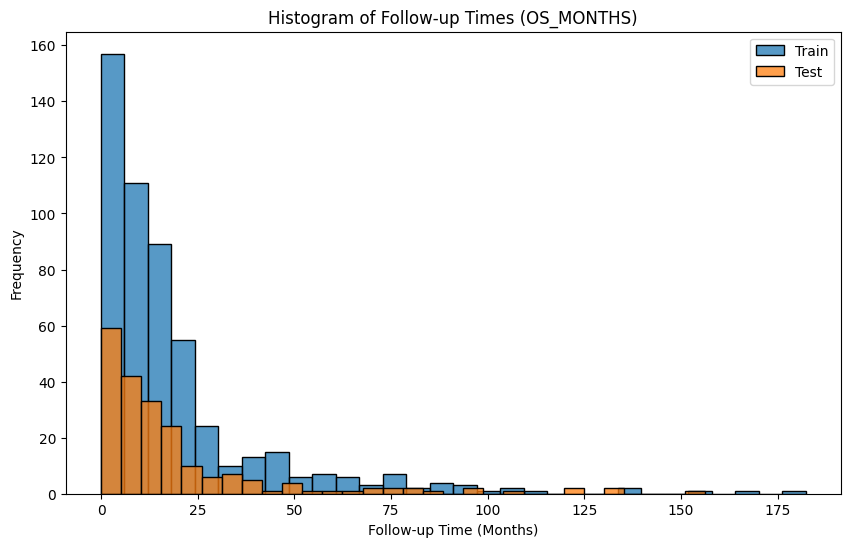

In [12]:
import matplotlib.pyplot as plt

data1 = train_dataset.ann["OS_MONTHS"]
data2 = test_dataset.ann["OS_MONTHS"]

# Create a histogram plot of OS_MONTHS for both train and test data
plt.figure(figsize=(10, 6))
sns.histplot(data1, bins=30, kde=False, label="Train")
sns.histplot(data2, bins=30, kde=False, label="Test")
plt.xlabel("Follow-up Time (Months)")
plt.ylabel("Frequency")
plt.title("Histogram of Follow-up Times (OS_MONTHS)")
plt.legend()
plt.show()

- Make a histogram of the age distribution of the patients in the training data; facet the histogram by "SEX" variable (see flexynesis.utils.plot_boxplot)

/home/thesamurai/micromamba/envs/flexynesisenv/lib/python3.11/site-packages/flexynesis/utils.py:155: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



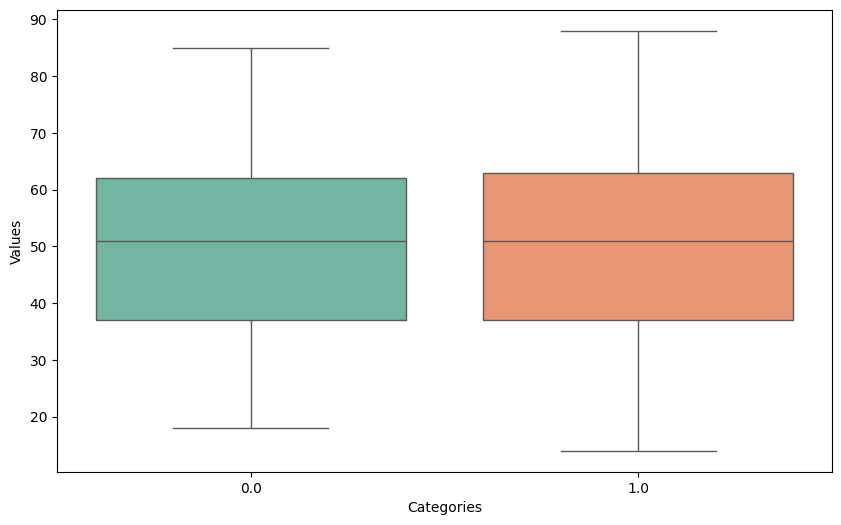

In [13]:
cat_x = train_dataset.ann["SEX"]
num_y = train_dataset.ann["AGE"]
flexynesis.utils.plot_boxplot(cat_x, num_y, title_x = 'Categories', title_y = 'Values')

- Make a summary of all available clinical variables (see flexynesis.print_summary_stats)

In [14]:
flexynesis.print_summary_stats(train_dataset)

Summary for variable: AGE
Numerical Variable Summary: Median = 51.0, Mean = 50.33781190019194
------
Summary for variable: OS_MONTHS
Numerical Variable Summary: Median = 11.6, Mean = 19.09097888675624
------
Summary for variable: OS_STATUS
Numerical Variable Summary: Median = 0.0, Mean = 0.36153846153846153
------
Summary for variable: KARNOFSKY_PERFORMANCE_SCORE
Numerical Variable Summary: Median = 80.0, Mean = 82.45454545454545
------
Summary for variable: STUDY
Categorical Variable Summary:
  Label: Brain Lower Grade Glioma, Count: 353
  Label: Glioblastoma multiforme, Count: 203
------
Summary for variable: BCR_STATUS
Categorical Variable Summary:
  Label: IGC, Count: 454
  Label: NCH, Count: 102
------
Summary for variable: HISTOLOGICAL_DIAGNOSIS
Categorical Variable Summary:
  Label: astrocytoma, Count: 115
  Label: glioblastoma, Count: 201
  Label: oligoastrocytoma, Count: 79
  Label: oligodendroglioma, Count: 126
  Label: nan, Count: 35
------
Summary for variable: SEX
Categori

- Notice that the categorical variables such as "SEX", "STUDY", "HISTOLOGICAL_DIAGNOSIS" are encoded numerically in the "dataset.ann" objects. Use dataset.label_mappings to map the STUDY variable to their original labels. 
Print the top 10 values in dataset.ann['STUDY'] and the mapped label values. 

In [15]:
train_dataset.label_mappings

{'STUDY': {0: 'Brain Lower Grade Glioma', 1: 'Glioblastoma multiforme'},
 'BCR_STATUS': {0: 'IGC', 1: 'NCH'},
 'HISTOLOGICAL_DIAGNOSIS': {0: 'astrocytoma',
  1: 'glioblastoma',
  2: 'oligoastrocytoma',
  3: 'oligodendroglioma',
  4: nan},
 'SEX': {0: 'Female', 1: 'Male', 2: nan}}

In [16]:
test_dataset.label_mappings

{'STUDY': {0: 'Brain Lower Grade Glioma', 1: 'Glioblastoma multiforme'},
 'BCR_STATUS': {0: 'IGC', 1: 'NCH'},
 'HISTOLOGICAL_DIAGNOSIS': {0: 'astrocytoma',
  1: 'glioblastoma',
  2: 'oligoastrocytoma',
  3: 'oligodendroglioma',
  4: nan},
 'SEX': {0: 'Female', 1: 'Male', 2: nan}}

In [17]:
import math
study_vals = train_dataset.ann["STUDY"][:10]
mapping = train_dataset.label_mappings["STUDY"]
df = pd.DataFrame({
    "STUDY": study_vals.tolist(),
    "Mapped Label": [
        mapping[int(x.item())] if not math.isnan(x.item()) else "NaN"
        for x in study_vals
    ]
})
display(df)

,STUDY,Mapped Label
0,0.0,Brain Lower Grade Glioma
1,1.0,Glioblastoma multiforme
2,0.0,Brain Lower Grade Glioma
3,1.0,Glioblastoma multiforme
4,0.0,Brain Lower Grade Glioma
5,0.0,Brain Lower Grade Glioma
6,0.0,Brain Lower Grade Glioma
7,0.0,Brain Lower Grade Glioma
8,0.0,Brain Lower Grade Glioma
9,0.0,Brain Lower Grade Glioma


- Now, let's explore the data matrices. Make a PCA plot of the mutation data matrix and color the samples by "HISTOLOGICAL_DIAGNOSIS". See flexynesis.plot_dim_reduced function

First create a pandas data frame with the data matrix of interest with feature and sample names 
> df = pd.DataFrame(train_dataset.dat['cna'], index = train_dataset.samples, columns= train_dataset.features['cna'])

Check the data frame contents 
> df.head()

Make a PCA plot of CNA values using the labels from the STUDY variable 

**Note**: if you couldn't map the labels above, you can also use train_dataset.dat['STUDY'] as labels  

In [18]:
df = pd.DataFrame(train_dataset.dat['cna'], index = train_dataset.samples, columns= train_dataset.features['cna'])

In [19]:
df.head()

,SLC30A8,ZNF273,CLEC5A,AGL,KCNA5,MIR603,SNTB1,MRPL13,MTBP,SNORA72|ENSG00000252158.1,...,CAV1,FZD1,BCAP29,MNX1,ADAM22,LRP8,NOM1,RN7SL290P,snoU13|ENSG00000239044.1,CPA1
TCGA-E1-A7YH,-0.109444,-0.613378,-0.726528,0.280691,0.247763,0.804383,-0.116035,-0.115879,-0.115879,-0.119240,...,-0.730570,-0.679642,-0.729876,-0.708711,-0.663208,0.297255,-0.708897,0.305912,-0.750277,-0.750277
TCGA-26-5134,-0.256765,-0.756259,-0.862503,0.383907,-0.217720,-1.534566,-0.265712,-0.265552,-0.265552,-0.268133,...,-0.866579,-0.830723,-0.867024,-0.843208,-0.806278,0.400502,-0.843390,0.410210,-0.884033,-0.884033
TCGA-FG-A710,-0.264657,-0.743652,-0.848905,-1.802629,-0.177821,0.575646,-0.273730,-0.273571,-0.273571,-0.276110,...,-0.871113,-0.817392,-0.871596,-0.829758,-0.793655,-1.786700,-0.829940,-1.799250,-0.888492,-0.888492
TCGA-14-0740,-0.222565,-0.731045,-0.853438,0.397488,0.723886,-0.453671,-0.230965,-0.230807,-0.230807,-0.252180,...,-0.857512,-0.804062,-0.857881,-0.872349,-0.781031,0.414087,-0.872530,0.423933,-0.875116,-0.875116
TCGA-CS-5397,-0.248872,0.445629,0.415661,0.386623,-0.241659,-0.814717,-0.257693,-0.257534,-0.257534,-0.260157,...,0.411910,0.440131,0.422172,0.421066,0.397198,0.403219,0.420842,0.412955,0.373274,0.373274


In [20]:
ds = train_dataset

In [21]:
f = 'STUDY'
labels = [ds.label_mappings[f][x] for x in ds.ann[f].numpy()] 

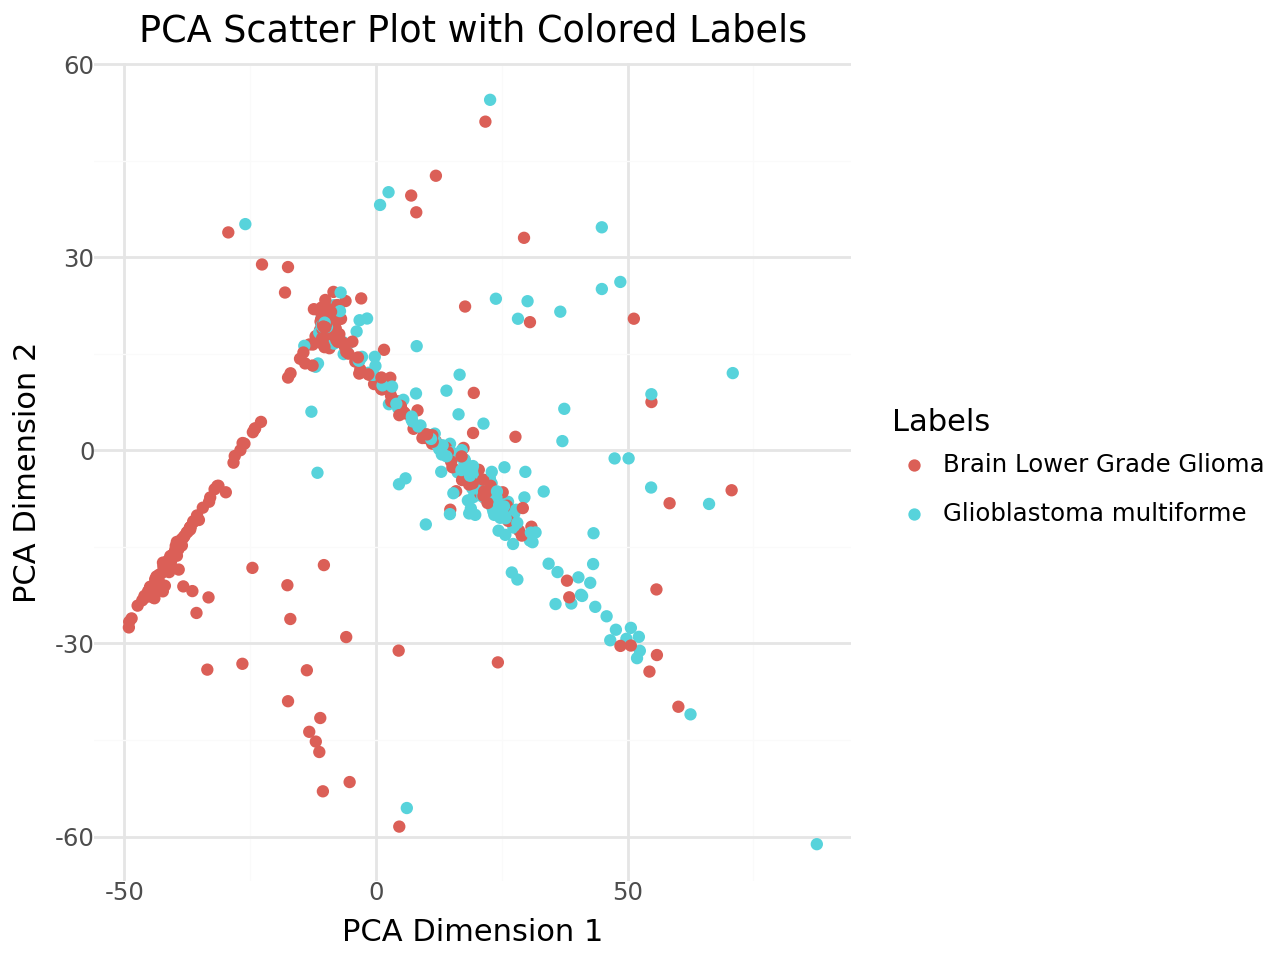

In [22]:
flexynesis.plot_dim_reduced(df, labels, color_type = 'categorical', method='pca')

- (Optional exercise ideas): 
    - Make a PCA plot coloring the samples by HISTOLOGICAL_DIAGNOSIS, GENDER, or any other clinical variable 
    - Repeat the same exercise on the mutation data matrix. 

In [23]:
from flexynesis import plot_dim_reduced

# List available clinical variables in the training dataset (from .ann)
clinical_vars = list(train_dataset.ann.keys())

# Prepare the data matrices for CNA and MUT
ds = train_dataset
df_cna = pd.DataFrame(ds.dat["cna"], index=ds.samples, columns=ds.features["cna"])
df_mut = pd.DataFrame(ds.dat["mut"], index=ds.samples, columns=ds.features["mut"])

def get_labels(variable):
    """
    For a given clinical variable, returns a tuple:
      (labels, color_type)
    If a mapping exists, labels are mapped (categorical);
    otherwise, raw values are returned (numerical).
    """
    vals = ds.ann[variable].numpy()
    if variable in ds.label_mappings:
        labels = [ds.label_mappings[variable][int(x.item())] if not math.isnan(x.item()) else "NaN" 
                  for x in ds.ann[variable]]
        color_type = "categorical"
    else:
        labels = vals  # Use raw numeric values
        color_type = "numerical"
    return labels, color_type

PCA plot for CNA data colored by: AGE


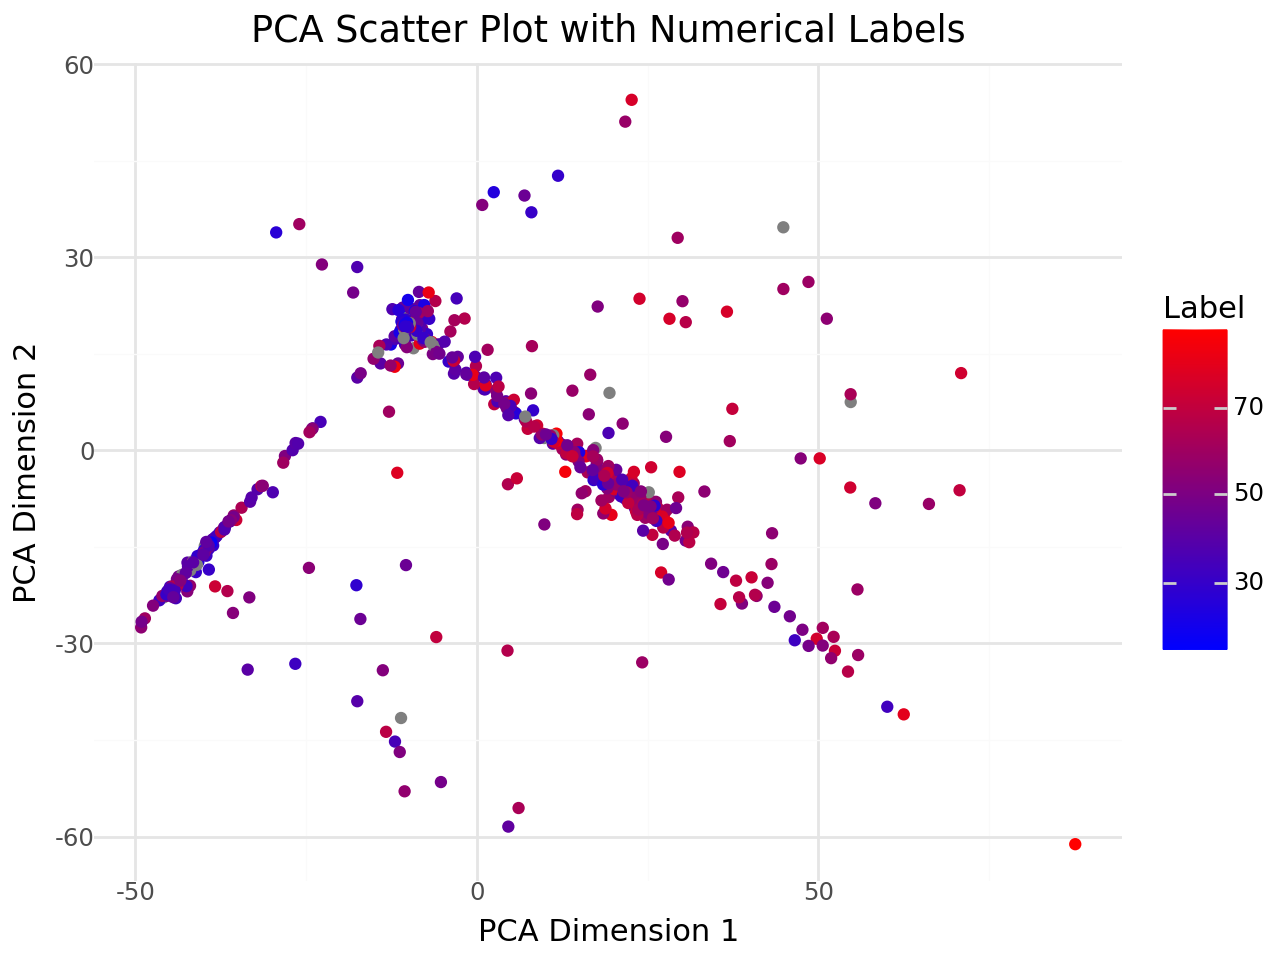

PCA plot for MUT data colored by: AGE


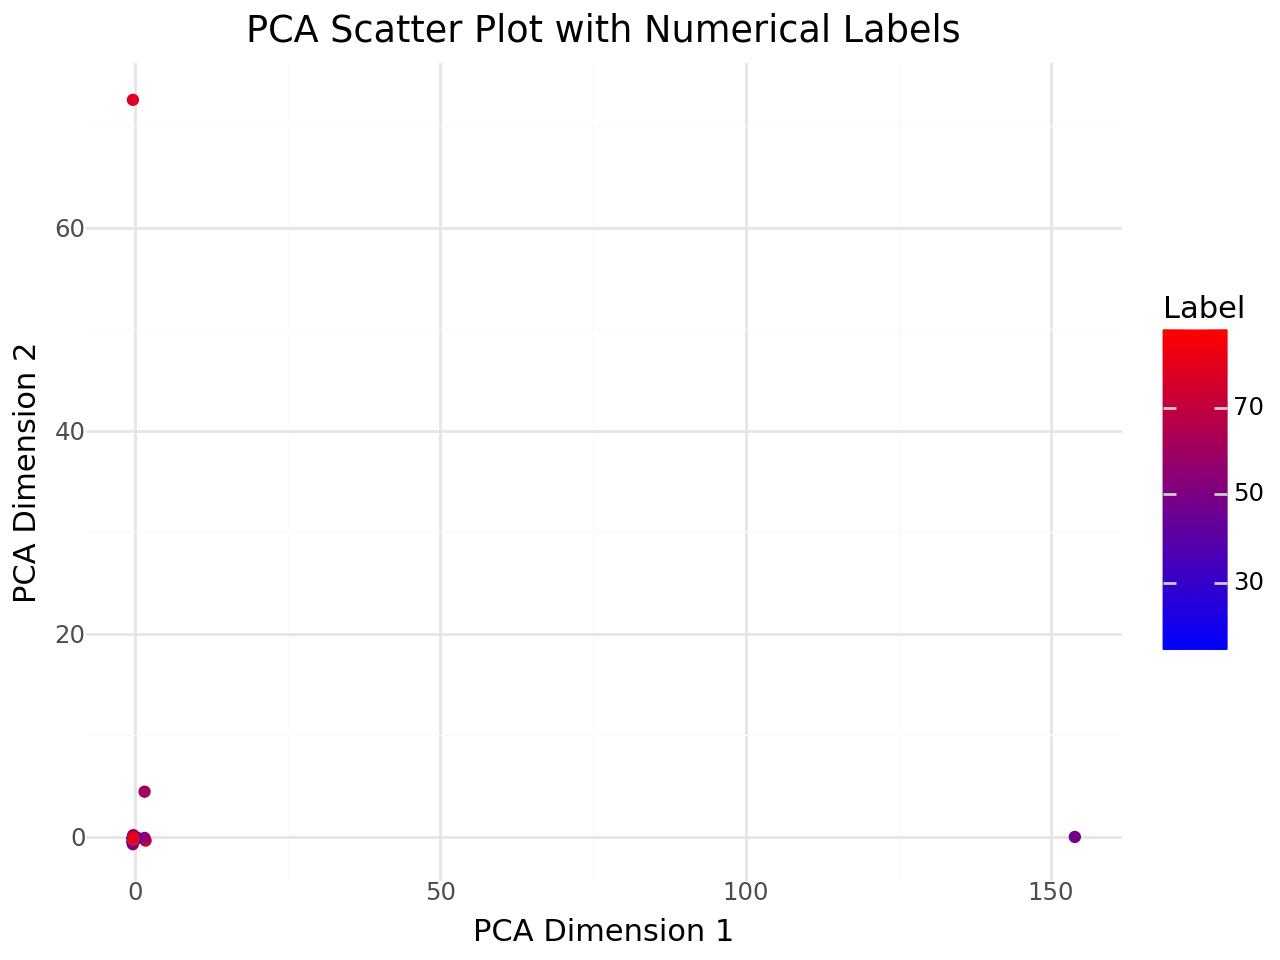

PCA plot for CNA data colored by: OS_MONTHS


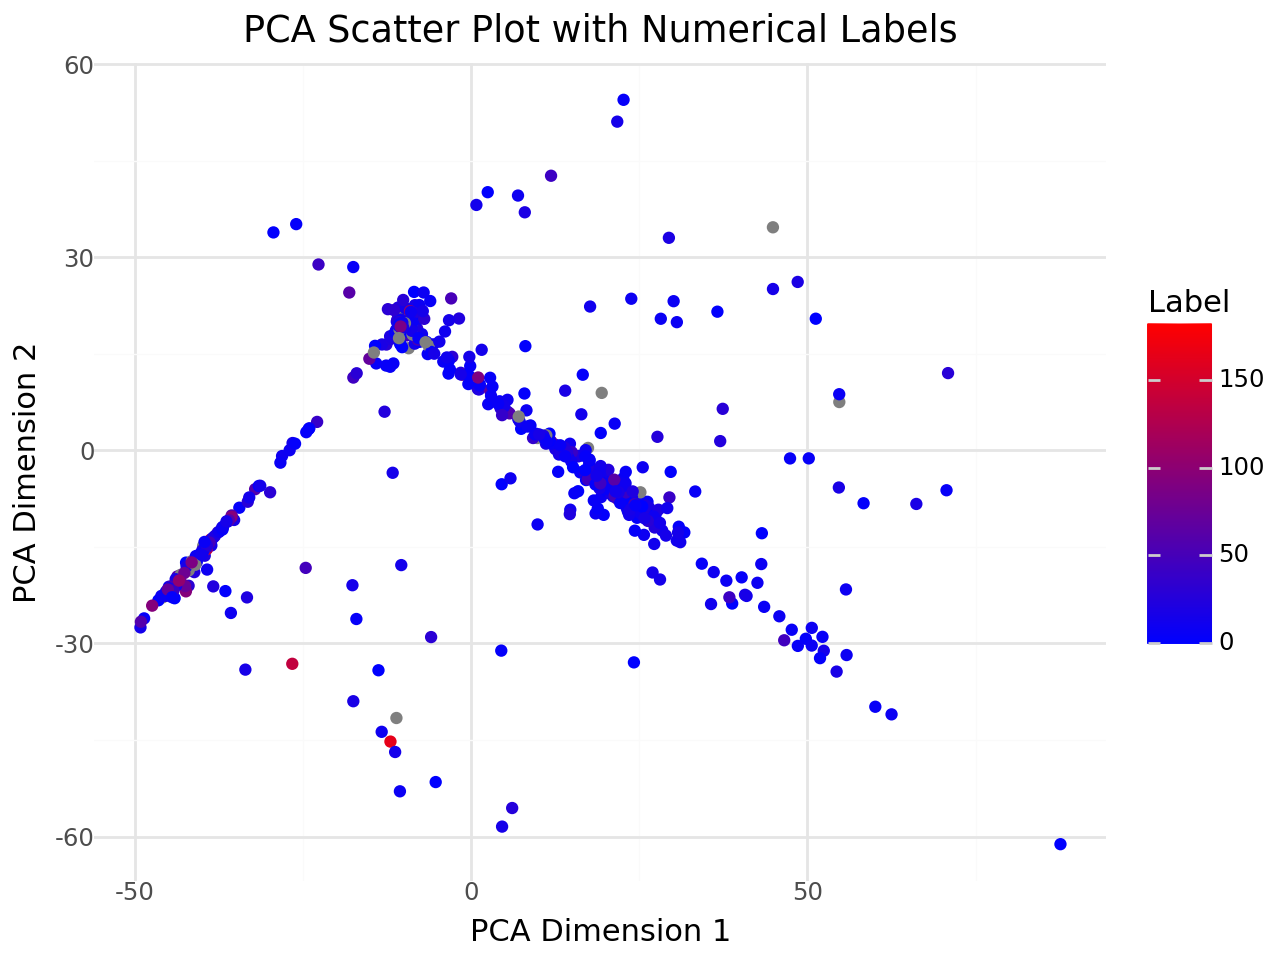

PCA plot for MUT data colored by: OS_MONTHS


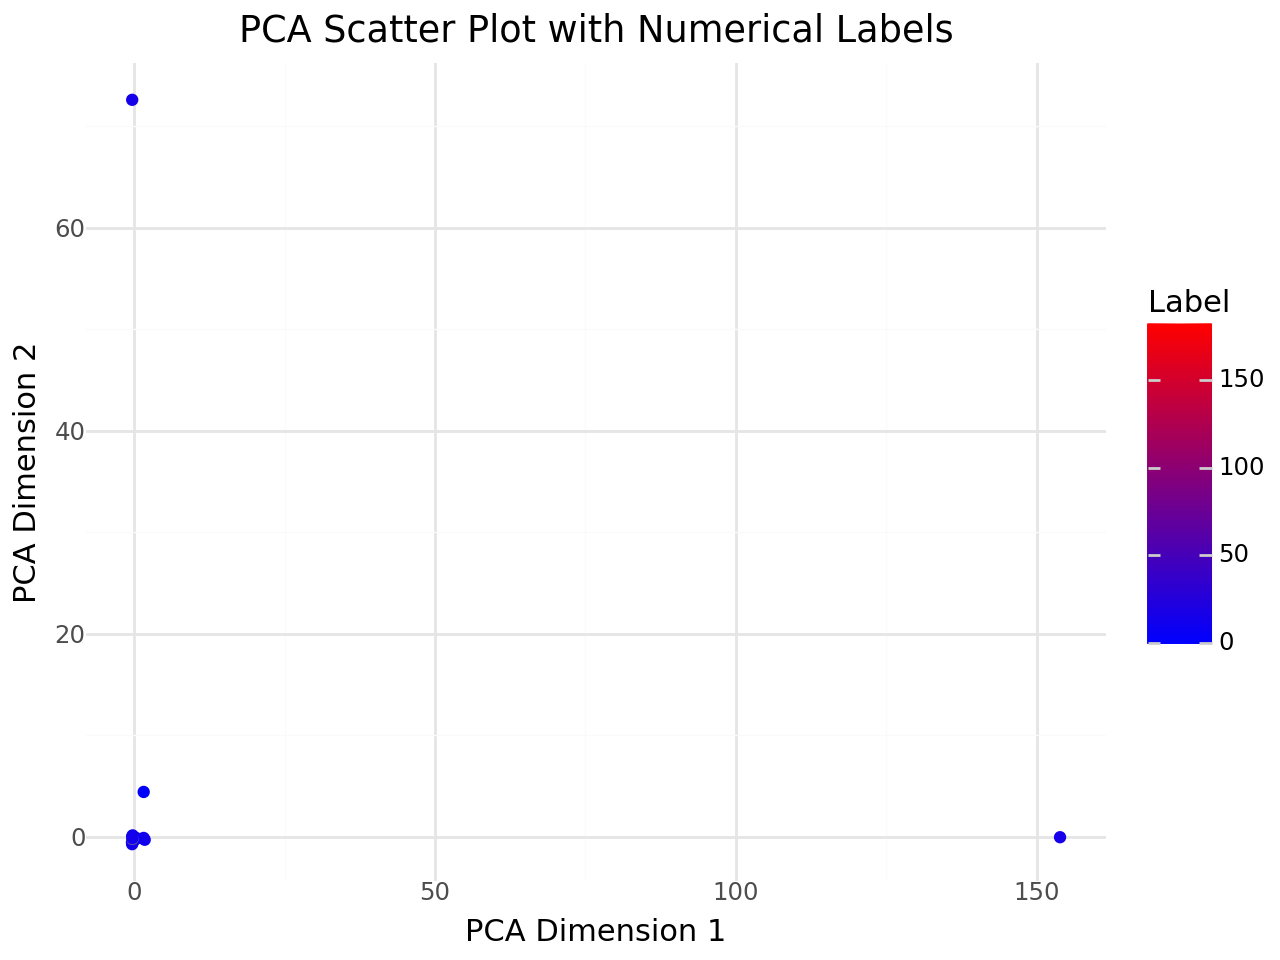

PCA plot for CNA data colored by: OS_STATUS


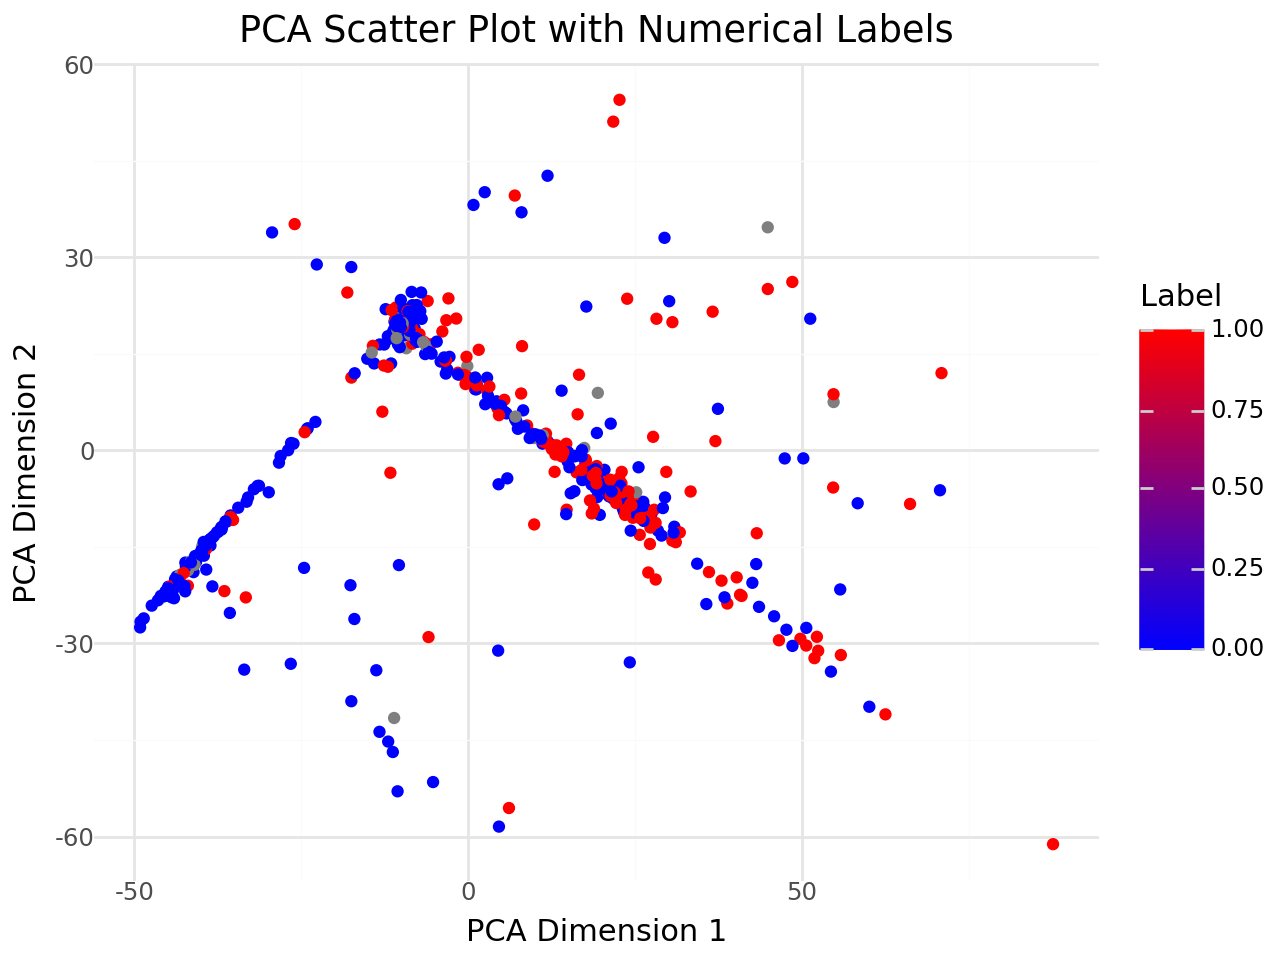

PCA plot for MUT data colored by: OS_STATUS


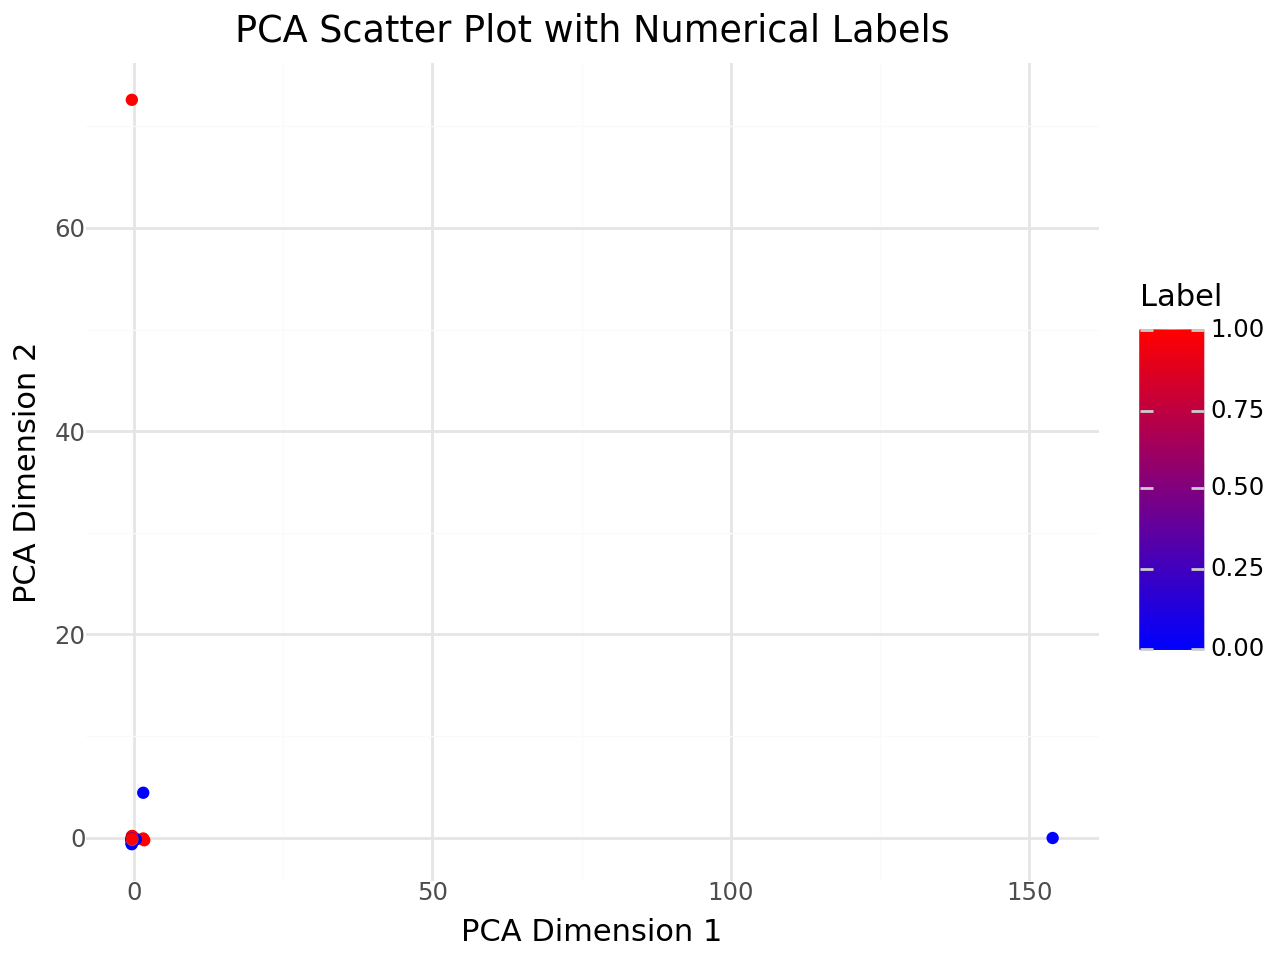

PCA plot for CNA data colored by: KARNOFSKY_PERFORMANCE_SCORE


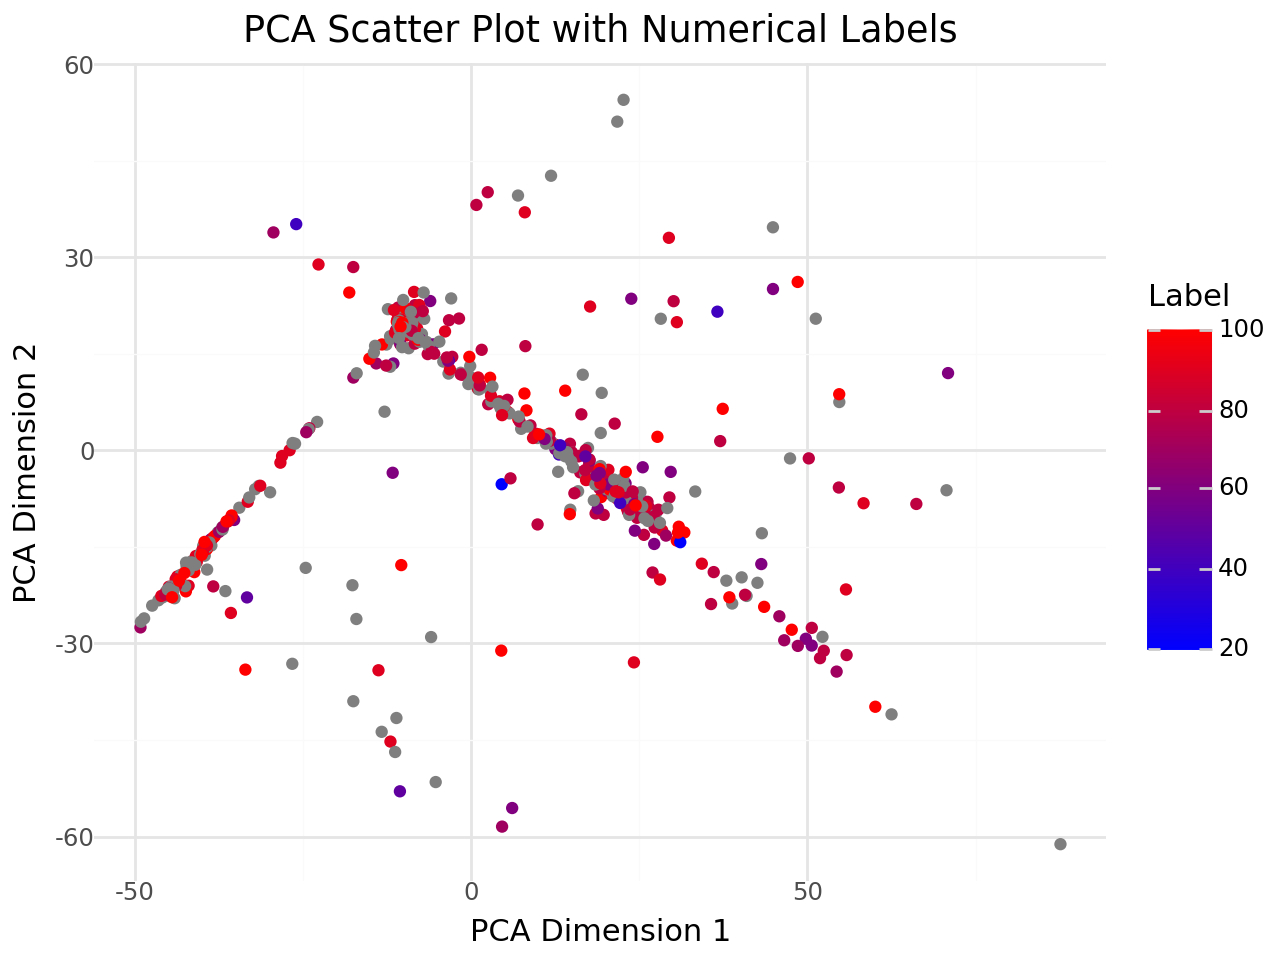

PCA plot for MUT data colored by: KARNOFSKY_PERFORMANCE_SCORE


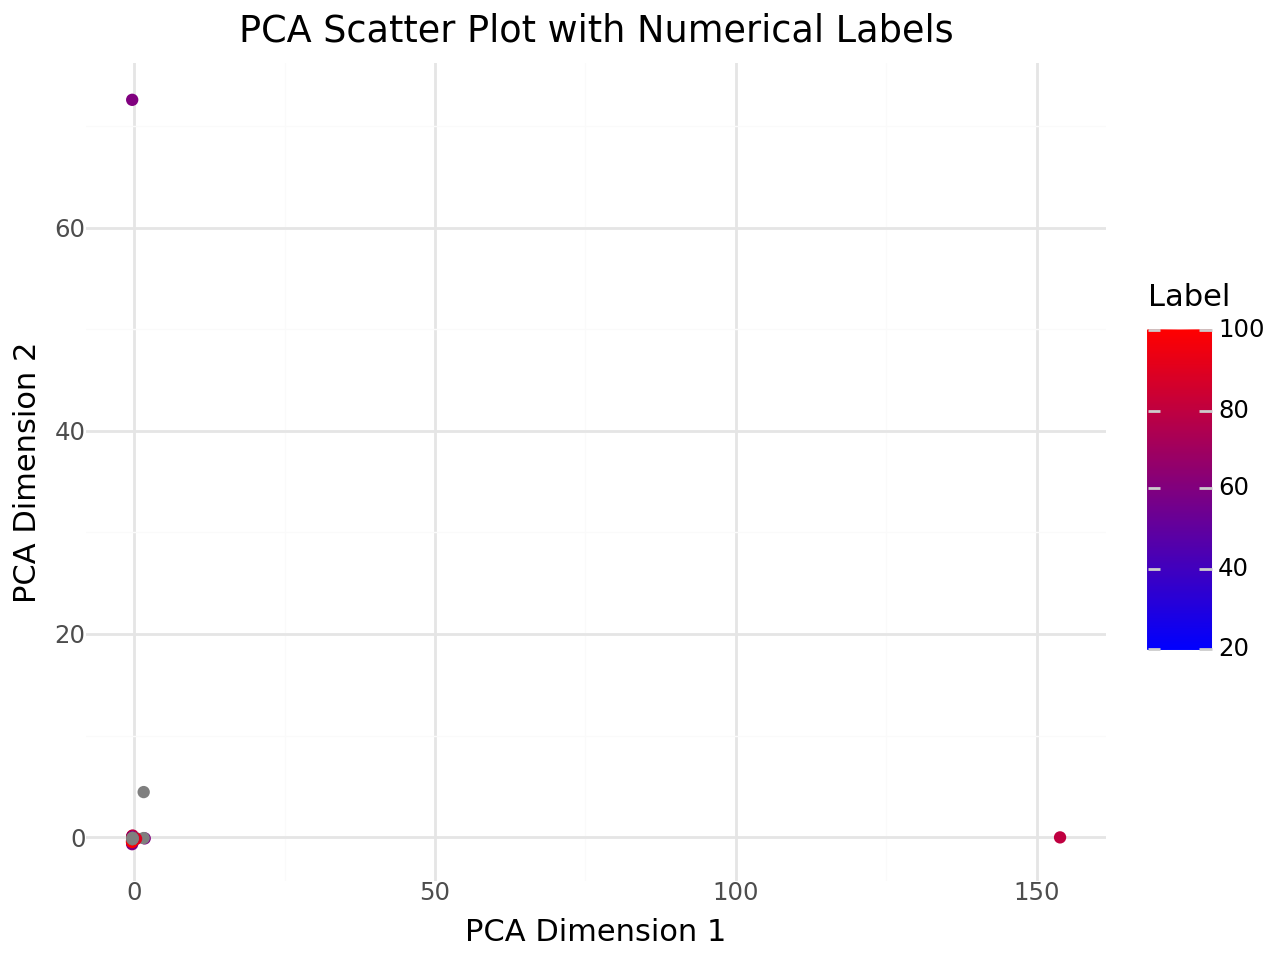

PCA plot for CNA data colored by: STUDY


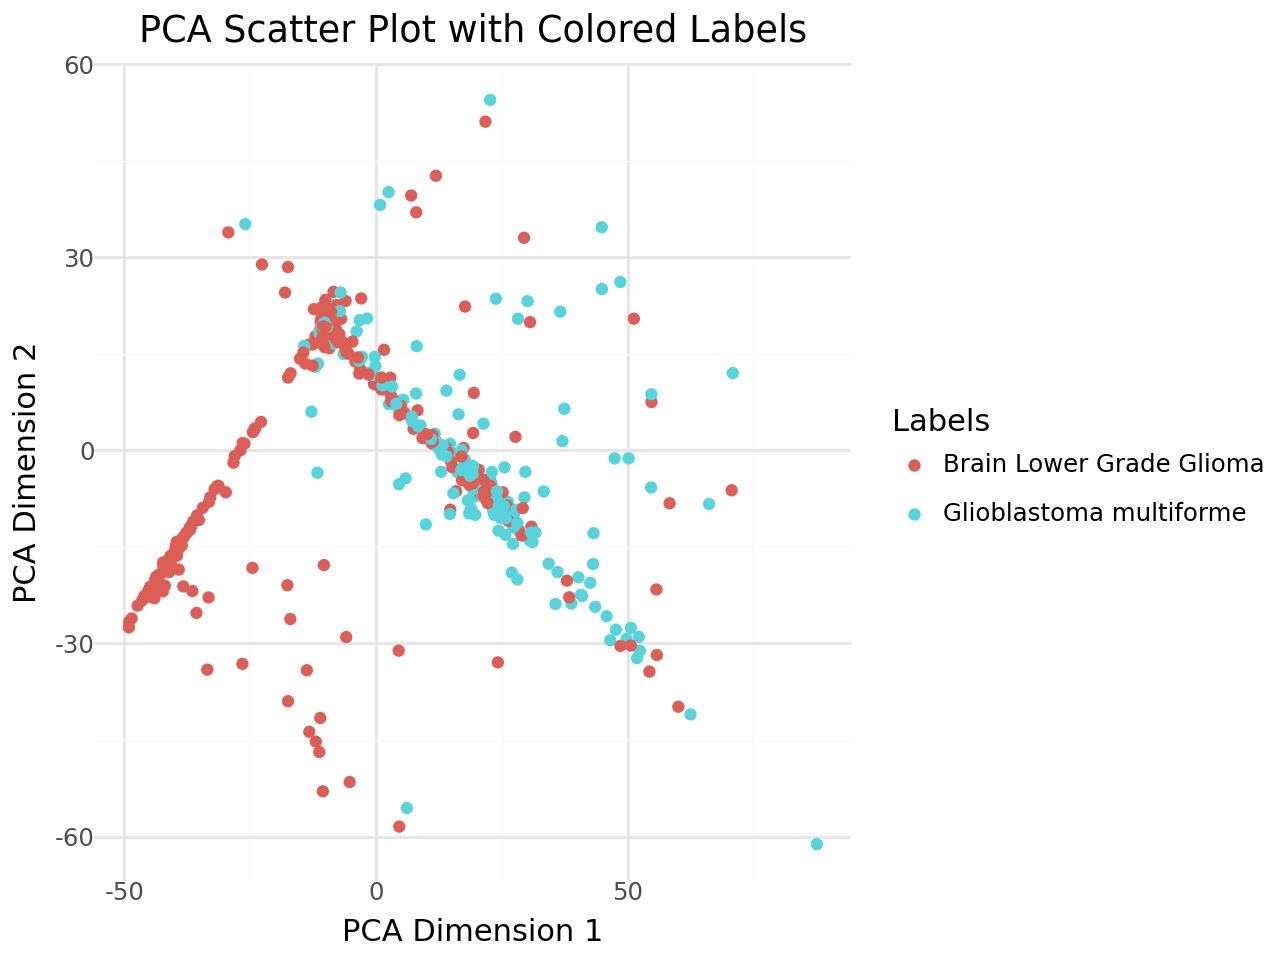

PCA plot for MUT data colored by: STUDY


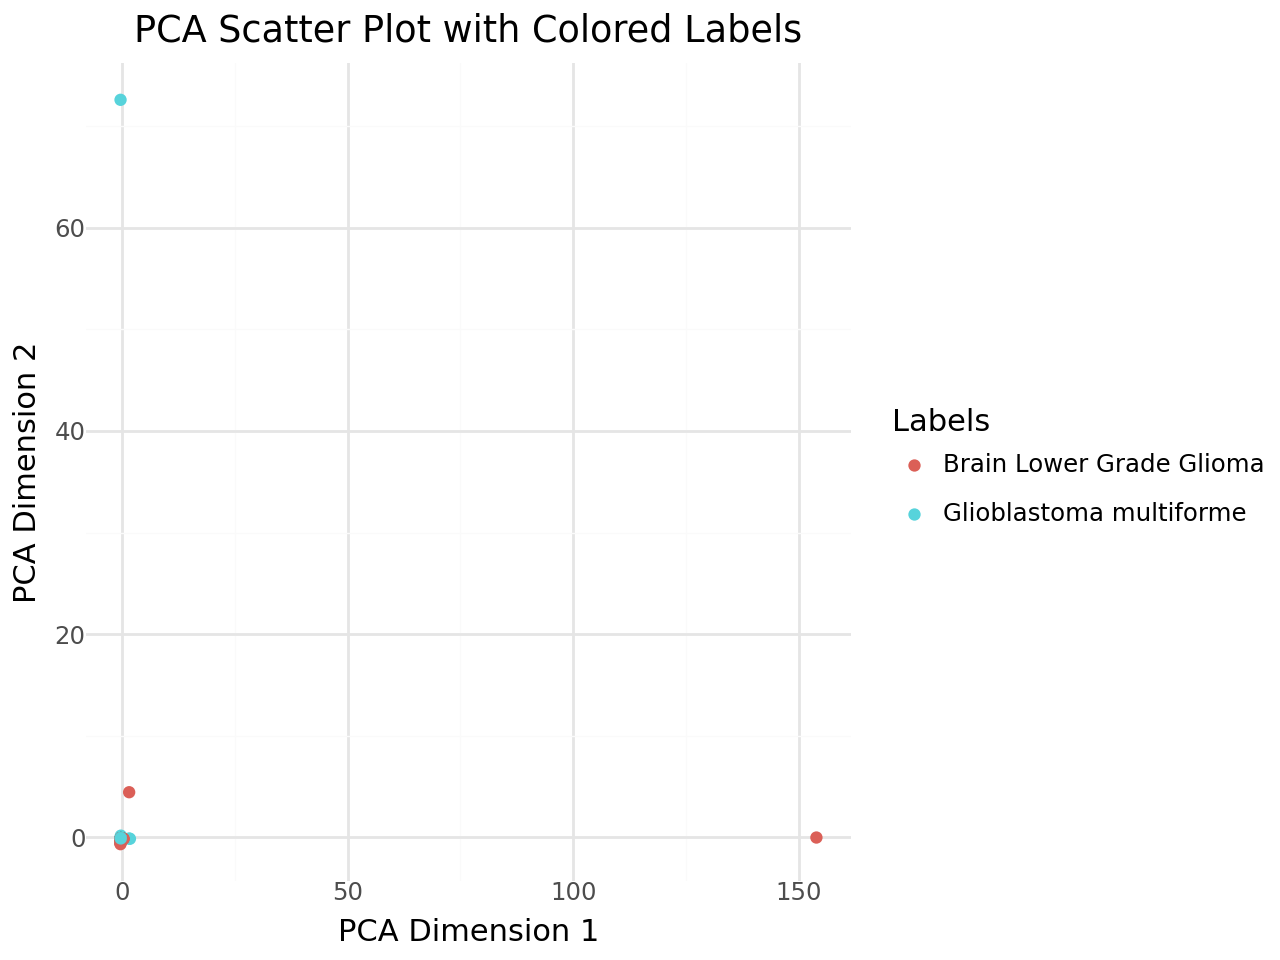

PCA plot for CNA data colored by: BCR_STATUS


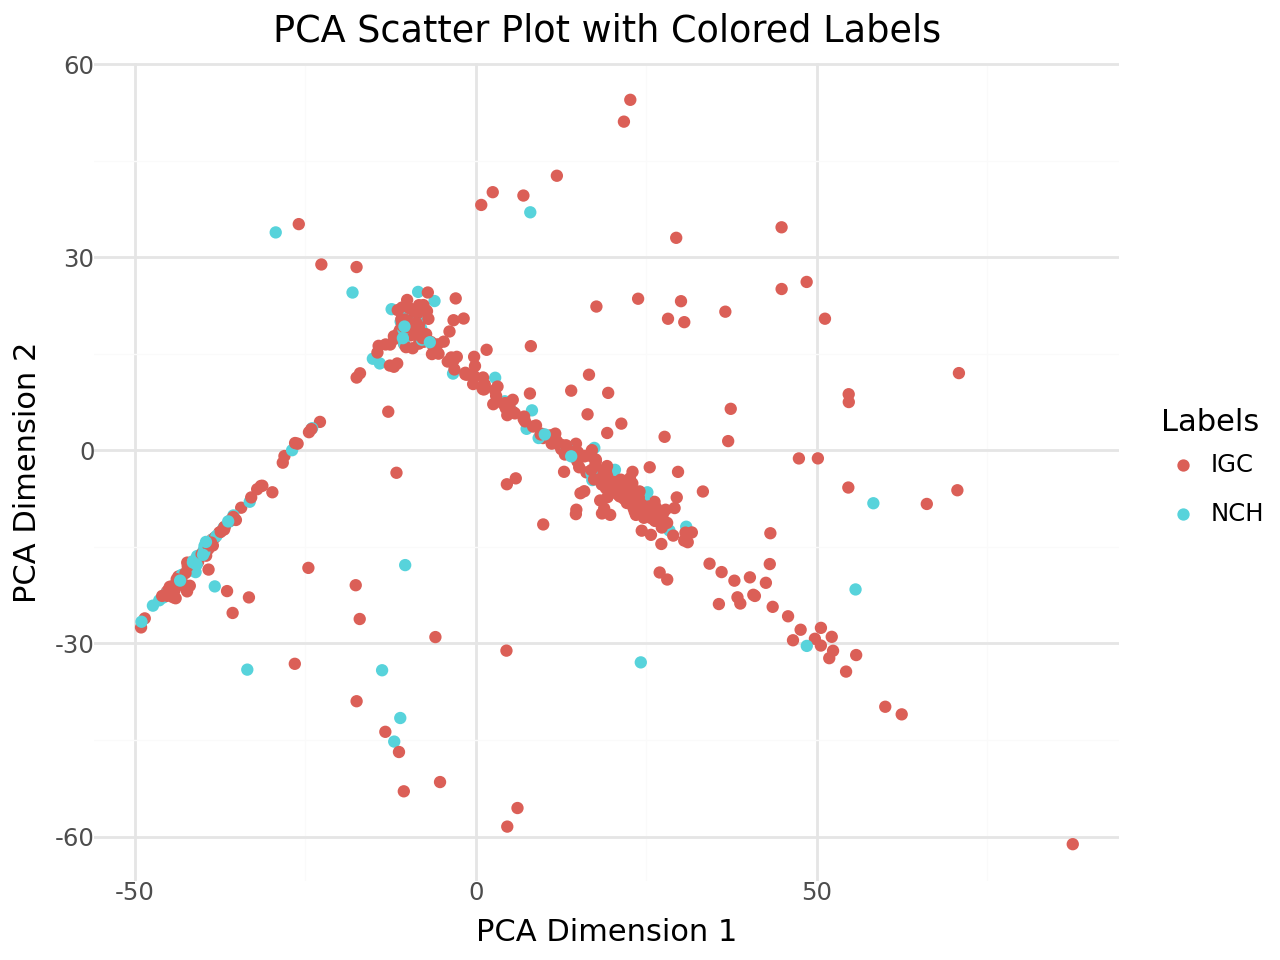

PCA plot for MUT data colored by: BCR_STATUS


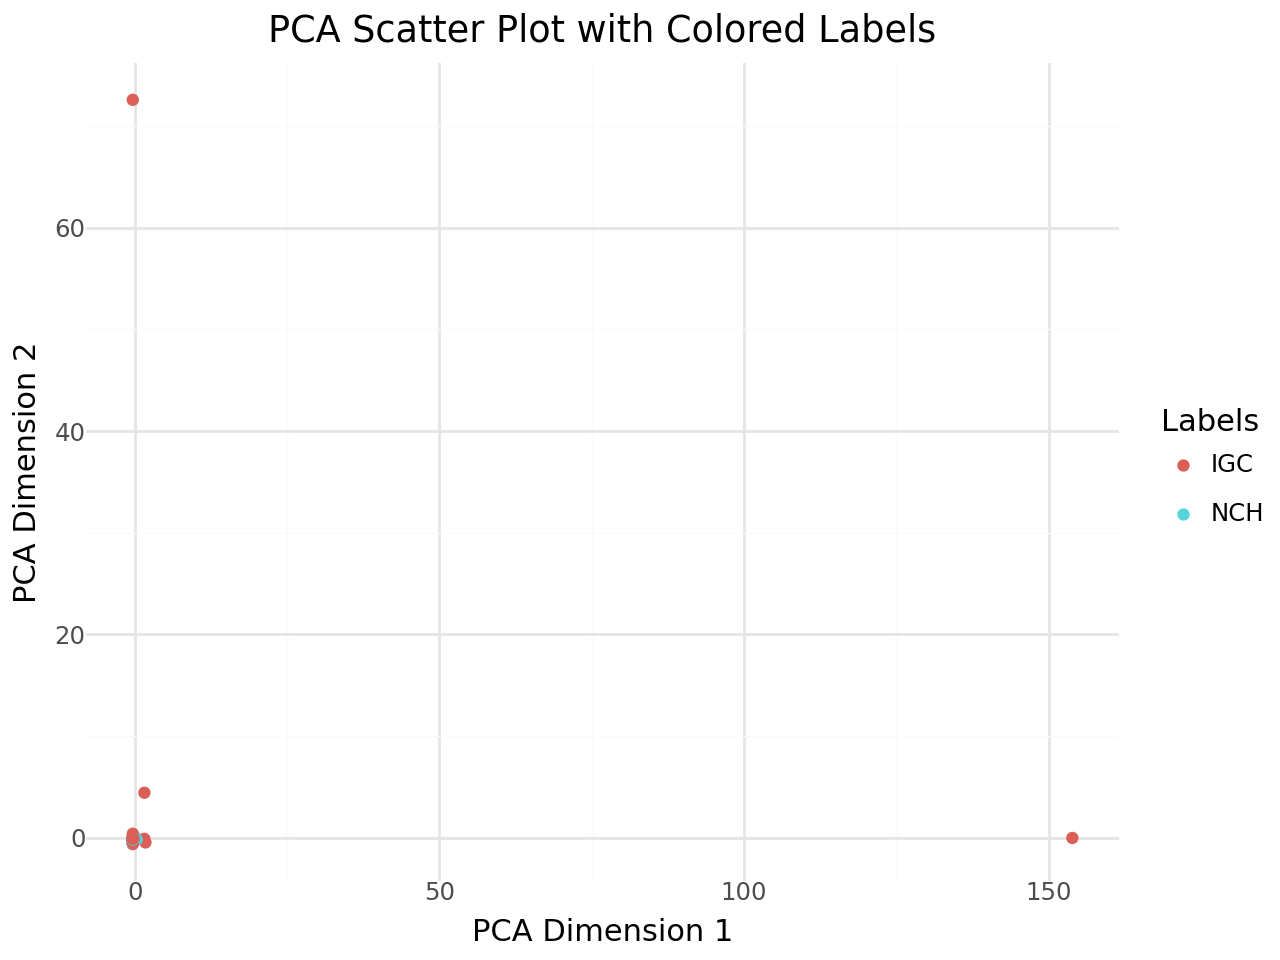

PCA plot for CNA data colored by: HISTOLOGICAL_DIAGNOSIS


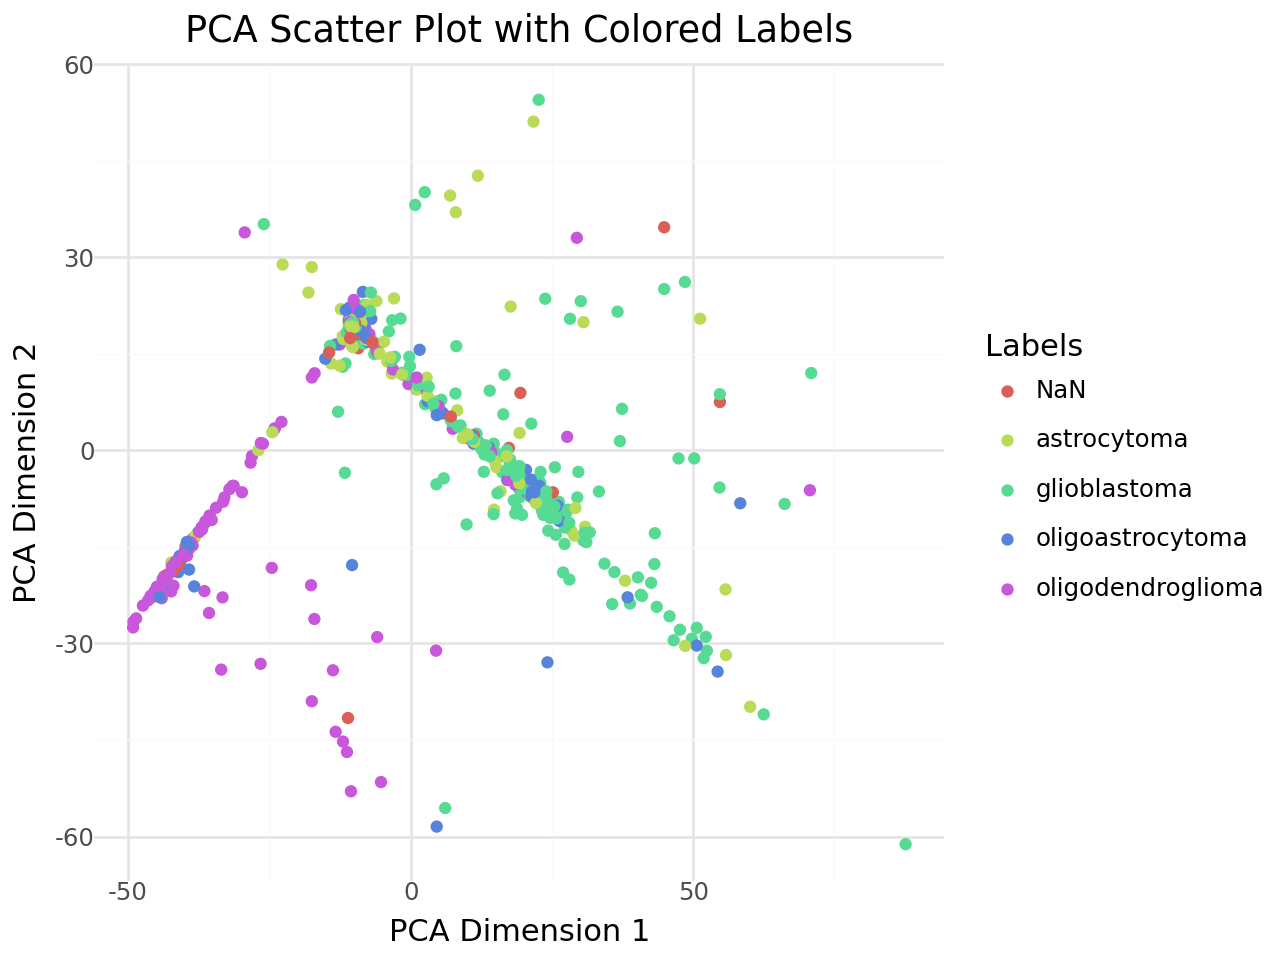

PCA plot for MUT data colored by: HISTOLOGICAL_DIAGNOSIS


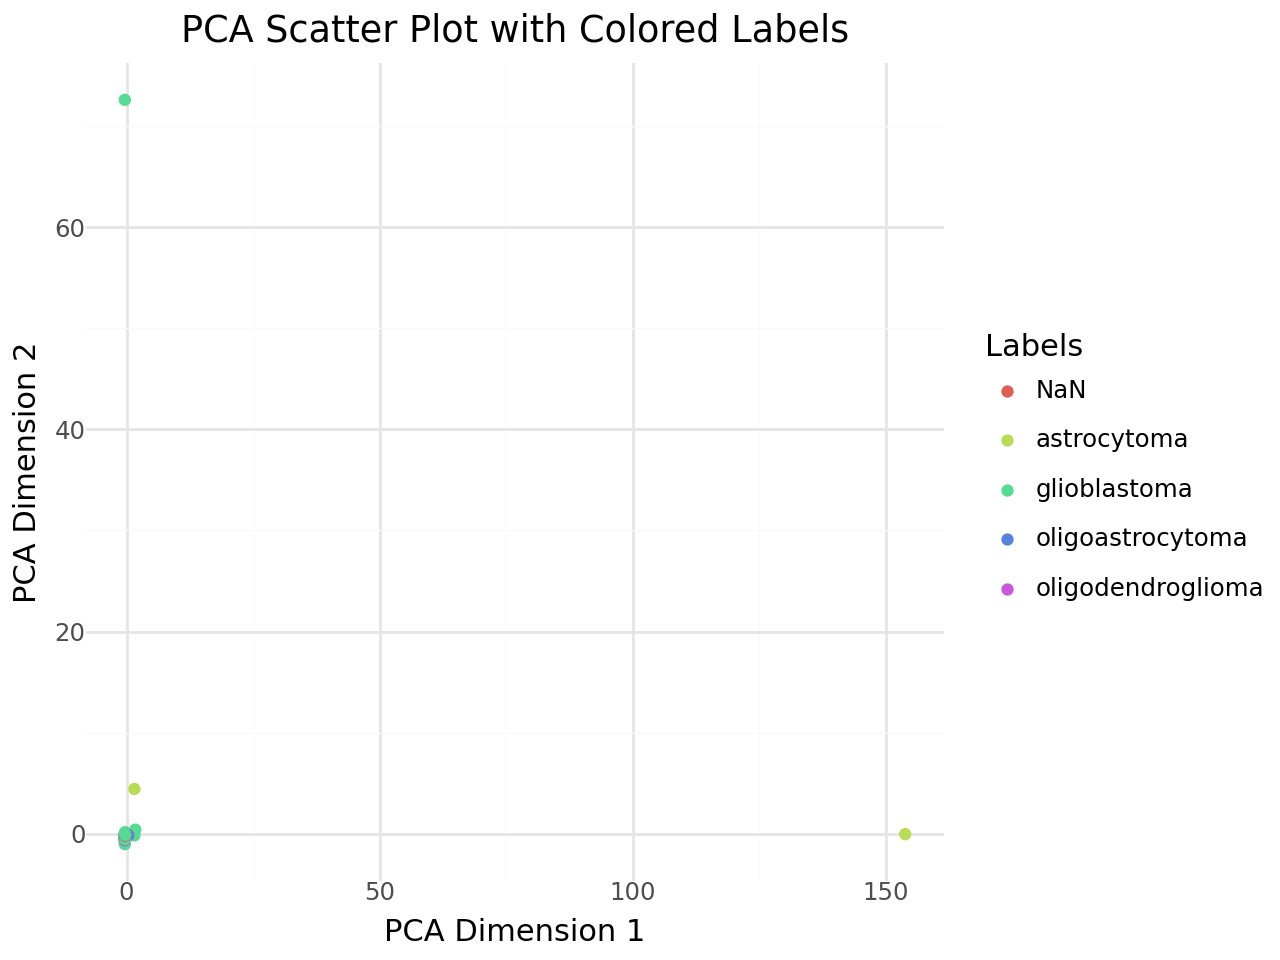

PCA plot for CNA data colored by: SEX


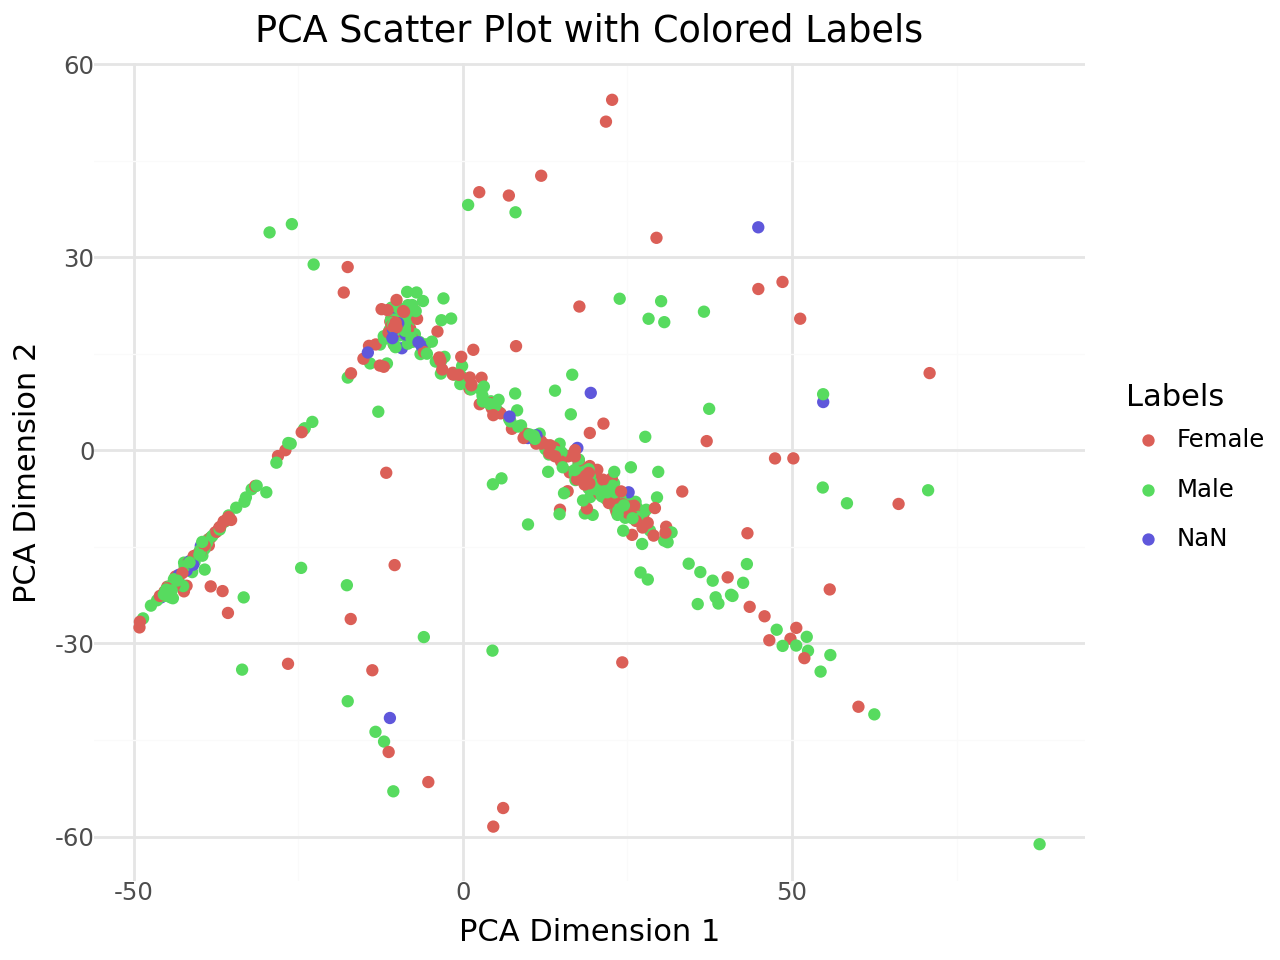

PCA plot for MUT data colored by: SEX


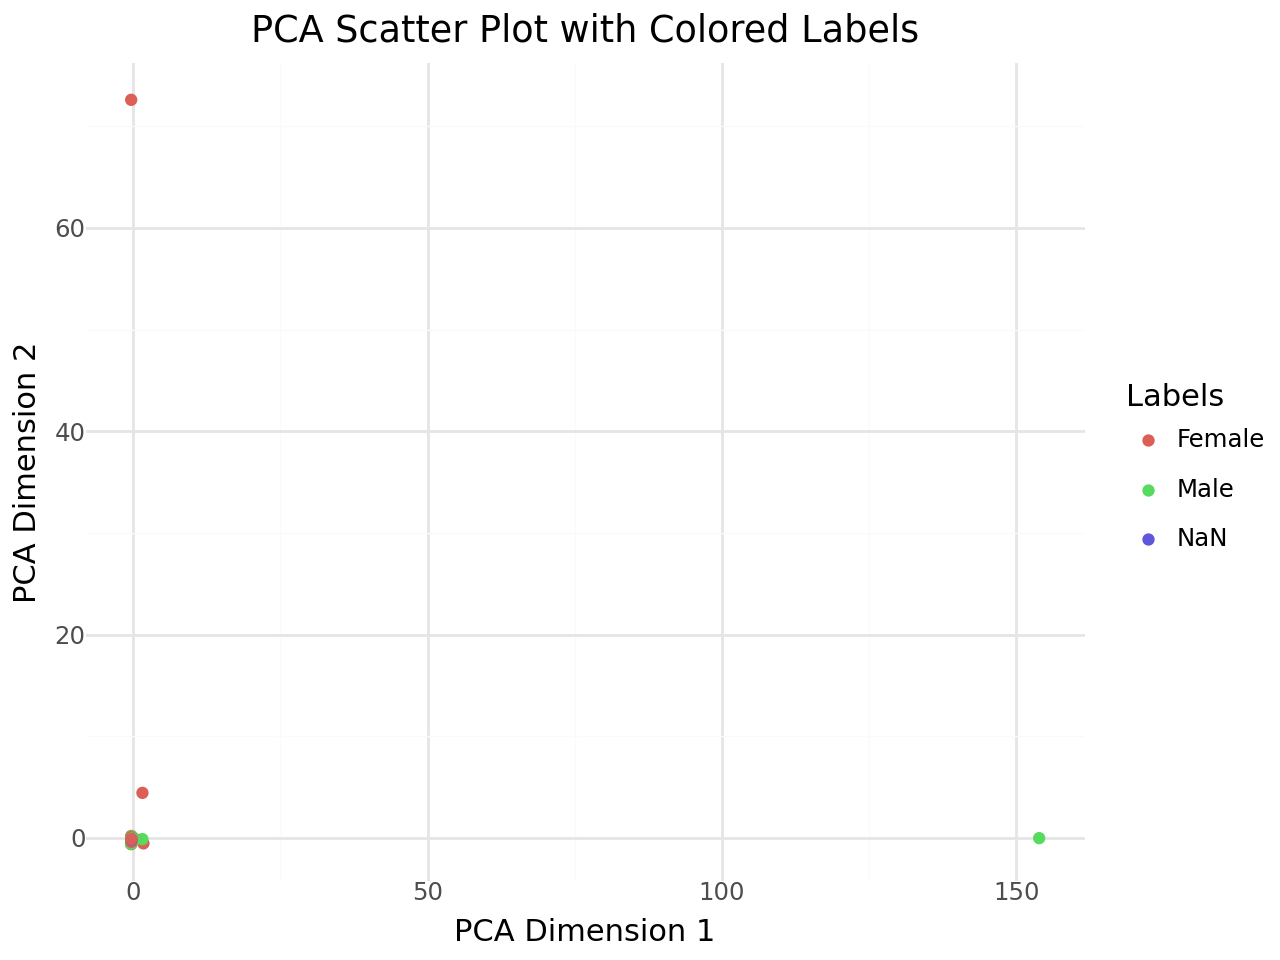

In [24]:
# Loop over each clinical variable and generate PCA plots for both CNA and MUT data
for var in clinical_vars:
    labels, color_type = get_labels(var)
    
    # Plot PCA for CNA data
    print(f"PCA plot for CNA data colored by: {var}")
    fig1 = plot_dim_reduced(df_cna, labels=labels, color_type=color_type, method="pca")
    # If fig is returned, display it:
    if fig1 is not None:
        fig1.show()
    else:
        plt1.show()
    
    # Plot PCA for MUT data
    print(f"PCA plot for MUT data colored by: {var}")
    fig2 = plot_dim_reduced(df_mut, labels=labels, color_type=color_type, method="pca")
    # If fig is returned, display it:
    if fig2 is not None:
        fig2.show()
    else:
        plt2.show()

## 2. Training a single model using manually set hyperparameters 

Now that we have familiarized ourselves with the dataset at hand, we can start building models. 

First we will do a single model training by manually setting hyperparameters. Based on the model performance, we will try modifying individual hyperparameters and build more and more models and see if we can improve model performance. 

We will need to define the following components for starting a model training:

    1. Split the train_dataset into train/validation components 
    2. Define data loaders for both train and validation splits 
    3. Define a pytorch-lightning trainer 
    4. Define a model with hyperparameters 
    5. Fit the model 

In [25]:
# randomly assign 80% of samples for training, 20% for validation 
train_indices = random.sample(range(0, len(train_dataset)), int(len(train_dataset) * 0.8))
val_indices = list(set(range(len(train_dataset))) - set(train_indices))
train_subset = train_dataset.subset(train_indices)
val_subset = train_dataset.subset(val_indices)

# define data loaders for train/validation splits 
from torch.utils.data import DataLoader
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True) 
val_loader = DataLoader(val_subset, batch_size=32, shuffle = False) 

Now, we need to define a model with manually set hyperparameters and a lightning-trainer fit the model. 

**Notice**: Notice the callback we are passing to the trainer which enables us to plot the loss values as the training progresses. 

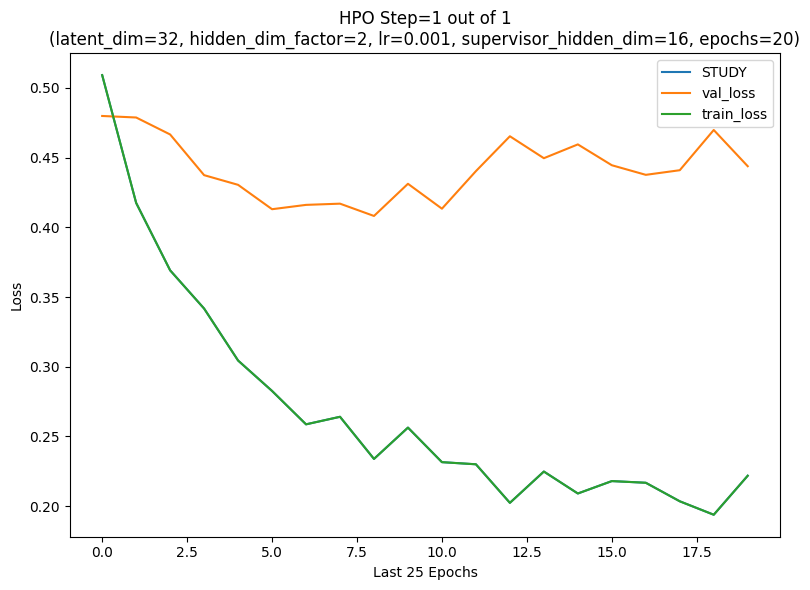

`Trainer.fit` stopped: `max_epochs=20` reached.


In [26]:
# Define a model with manually set hyperparameters for the DirectPred model 
myparams = {'latent_dim': 32, 'hidden_dim_factor': 2, 'lr': 0.001, 'supervisor_hidden_dim': 16, 'epochs': 20}
model = flexynesis.DirectPred(config = myparams, dataset = train_dataset, target_variables=['STUDY'])   
trainer = pl.Trainer(max_epochs=myparams['epochs'], default_root_dir="./", logger=False, enable_checkpointing=False, 
                     callbacks=[flexynesis.LiveLossPlot(myparams, 1, 1)])
# Fit the model 
trainer.fit(model, train_loader, val_loader)

While we can observe how well the model training went based on the "loss" values, we can also evaluate the model performance on test dataset 

In [27]:
# evaluate the model performance on predicting the target variable
flexynesis.evaluate_wrapper("DirectPred", model.predict(test_dataset), test_dataset)

,method,var,variable_type,metric,value
0,DirectPred,STUDY,categorical,balanced_acc,0.805882
1,DirectPred,STUDY,categorical,f1_score,0.812813
2,DirectPred,STUDY,categorical,kappa,0.597701
3,DirectPred,STUDY,categorical,average_auroc,0.872126
4,DirectPred,STUDY,categorical,average_aupr,0.754553


## 2.1 Exercise

- Now, repeat the above model training and evaluation by manually changing the hyperparameters (Try at least 5 different combinations)
- See if you can find a better hyperparameter combination that yields a better classification performance than the initial setup we provided. 
- See the default hyperparameter ranges we use for Flexynesis here: https://github.com/BIMSBbioinfo/flexynesis/blob/69b92ca9370551e9fcc82a756cb42c72bef4a4b1/flexynesis/config.py#L7, but feel free to try outside these ranges too. 
- Also try to observe the impact of the changing parameters on how the train/validation loss curves change. 

    myparams = {'latent_dim': XX, 'hidden_dim_factor': XX, 'lr': XX, 'supervisor_hidden_dim': XX, 'epochs': XX}

    model = flexynesis.DirectPred(config = myparams, dataset = train_dataset, target_variables=['STUDY'])   

    trainer = pl.Trainer(max_epochs=myparams['epochs'], default_root_dir="./", logger=False, enable_checkpointing=False, 
                         callbacks=[flexynesis.LiveLossPlot(myparams, 1, 1)])

    trainer.fit(model, train_loader, val_loader)
    
    flexynesis.evaluate_wrapper("DirectPred", model.predict(test_dataset), test_dataset)

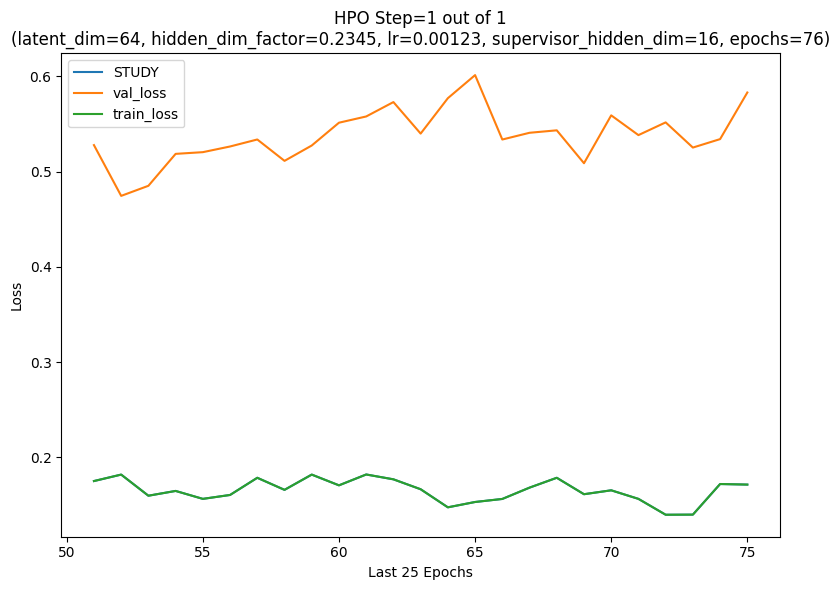

`Trainer.fit` stopped: `max_epochs=76` reached.


,method,var,variable_type,metric,value
0,DirectPred,STUDY,categorical,balanced_acc,0.777124
1,DirectPred,STUDY,categorical,f1_score,0.794382
2,DirectPred,STUDY,categorical,kappa,0.552803
3,DirectPred,STUDY,categorical,average_auroc,0.862668
4,DirectPred,STUDY,categorical,average_aupr,0.757702


In [28]:
# Define a model with manually set hyperparameters for the DirectPred model 
myparams = {'latent_dim': 64, 'hidden_dim_factor': 0.2345, 'lr': 0.00123, 'supervisor_hidden_dim': 16, 'epochs': 76}
model = flexynesis.DirectPred(config = myparams, dataset = train_dataset, target_variables=['STUDY'])   
trainer = pl.Trainer(max_epochs=myparams['epochs'], default_root_dir="./", logger=False, enable_checkpointing=False, 
                     callbacks=[flexynesis.LiveLossPlot(myparams, 1, 1)])
# Fit the model 
trainer.fit(model, train_loader, val_loader)
flexynesis.evaluate_wrapper("DirectPred", model.predict(test_dataset), test_dataset)

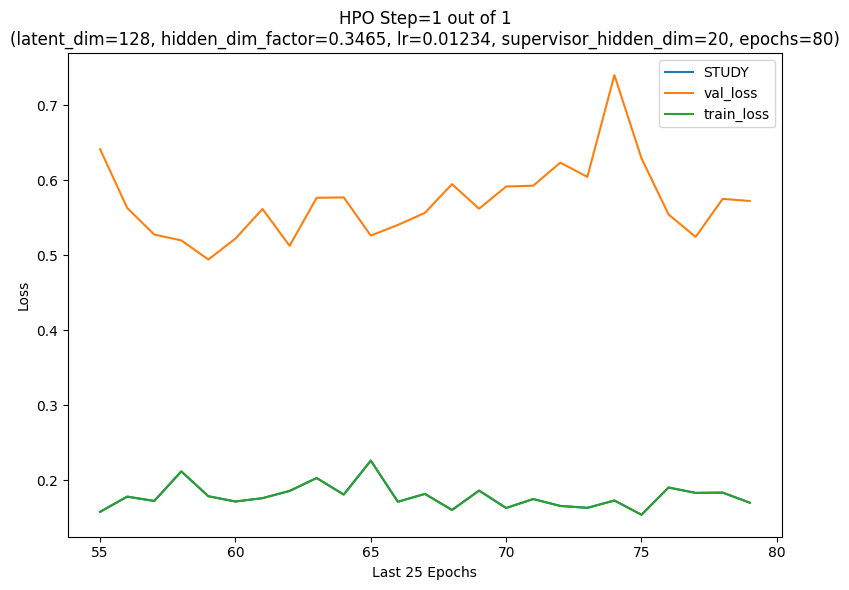

`Trainer.fit` stopped: `max_epochs=80` reached.


,method,var,variable_type,metric,value
0,DirectPred,STUDY,categorical,balanced_acc,0.747059
1,DirectPred,STUDY,categorical,f1_score,0.780352
2,DirectPred,STUDY,categorical,kappa,0.514286
3,DirectPred,STUDY,categorical,average_auroc,0.833910
4,DirectPred,STUDY,categorical,average_aupr,0.700429


In [29]:
# Define a model with manually set hyperparameters for the DirectPred model 
myparams = {'latent_dim': 128, 'hidden_dim_factor': 0.3465, 'lr': 0.01234, 'supervisor_hidden_dim': 20, 'epochs': 80}
model = flexynesis.DirectPred(config = myparams, dataset = train_dataset, target_variables=['STUDY'])   
trainer = pl.Trainer(max_epochs=myparams['epochs'], default_root_dir="./", logger=False, enable_checkpointing=False, 
                     callbacks=[flexynesis.LiveLossPlot(myparams, 1, 1)])
# Fit the model 
trainer.fit(model, train_loader, val_loader)
flexynesis.evaluate_wrapper("DirectPred", model.predict(test_dataset), test_dataset)

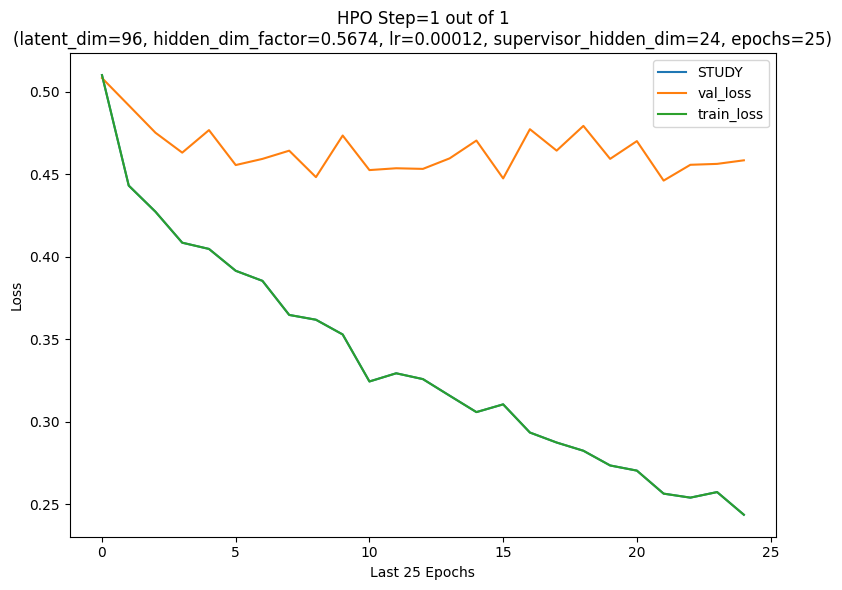

`Trainer.fit` stopped: `max_epochs=25` reached.


,method,var,variable_type,metric,value
0,DirectPred,STUDY,categorical,balanced_acc,0.791503
1,DirectPred,STUDY,categorical,f1_score,0.803702
2,DirectPred,STUDY,categorical,kappa,0.575484
3,DirectPred,STUDY,categorical,average_auroc,0.850827
4,DirectPred,STUDY,categorical,average_aupr,0.736489


In [30]:
# Define a model with manually set hyperparameters for the DirectPred model 
myparams = {'latent_dim': 96, 'hidden_dim_factor': 0.5674, 'lr': 0.00012, 'supervisor_hidden_dim': 24, 'epochs': 25}
model = flexynesis.DirectPred(config = myparams, dataset = train_dataset, target_variables=['STUDY'])   
trainer = pl.Trainer(max_epochs=myparams['epochs'], default_root_dir="./", logger=False, enable_checkpointing=False, 
                     callbacks=[flexynesis.LiveLossPlot(myparams, 1, 1)])
# Fit the model 
trainer.fit(model, train_loader, val_loader)
flexynesis.evaluate_wrapper("DirectPred", model.predict(test_dataset), test_dataset)

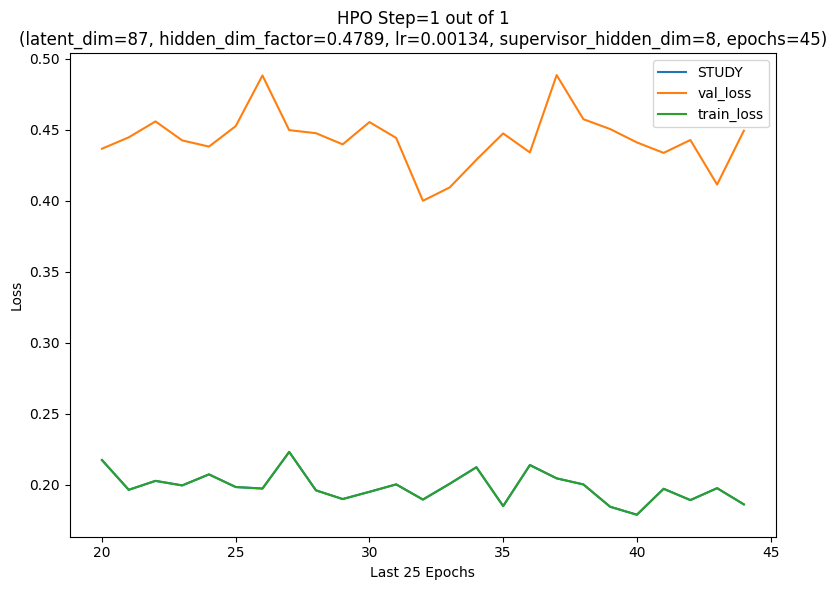

`Trainer.fit` stopped: `max_epochs=45` reached.


,method,var,variable_type,metric,value
0,DirectPred,STUDY,categorical,balanced_acc,0.805229
1,DirectPred,STUDY,categorical,f1_score,0.823052
2,DirectPred,STUDY,categorical,kappa,0.613666
3,DirectPred,STUDY,categorical,average_auroc,0.873356
4,DirectPred,STUDY,categorical,average_aupr,0.782998


In [31]:
# Define a model with manually set hyperparameters for the DirectPred model 
myparams = {'latent_dim': 87, 'hidden_dim_factor': 0.4789, 'lr': 0.00134, 'supervisor_hidden_dim': 8, 'epochs': 45}
model = flexynesis.DirectPred(config = myparams, dataset = train_dataset, target_variables=['STUDY'])   
trainer = pl.Trainer(max_epochs=myparams['epochs'], default_root_dir="./", logger=False, enable_checkpointing=False, 
                     callbacks=[flexynesis.LiveLossPlot(myparams, 1, 1)])
# Fit the model 
trainer.fit(model, train_loader, val_loader)
flexynesis.evaluate_wrapper("DirectPred", model.predict(test_dataset), test_dataset)

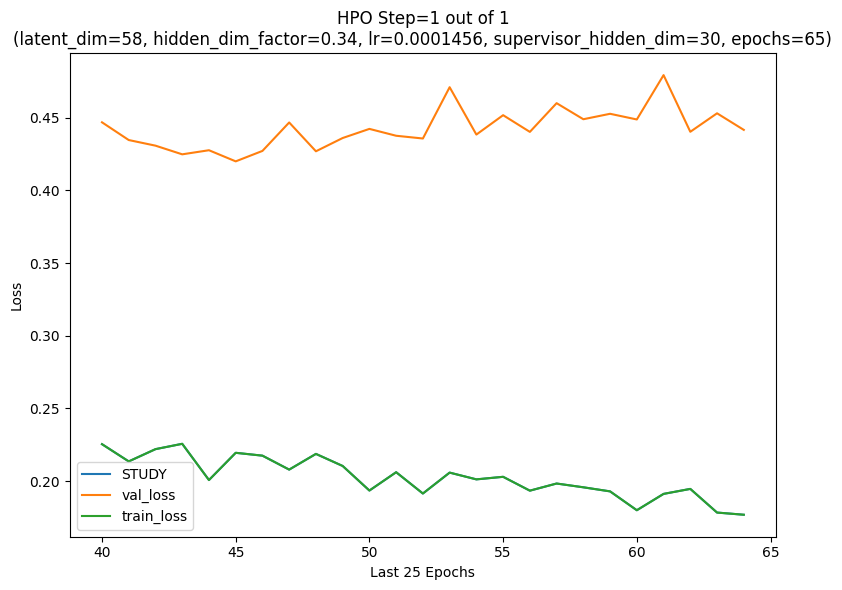

`Trainer.fit` stopped: `max_epochs=65` reached.


,method,var,variable_type,metric,value
0,DirectPred,STUDY,categorical,balanced_acc,0.767320
1,DirectPred,STUDY,categorical,f1_score,0.782577
2,DirectPred,STUDY,categorical,kappa,0.529107
3,DirectPred,STUDY,categorical,average_auroc,0.861207
4,DirectPred,STUDY,categorical,average_aupr,0.765399


In [32]:
# Define a model with manually set hyperparameters for the DirectPred model 
myparams = {'latent_dim': 58, 'hidden_dim_factor': 0.34, 'lr': 0.0001456, 'supervisor_hidden_dim': 30, 'epochs': 65}
model = flexynesis.DirectPred(config = myparams, dataset = train_dataset, target_variables=['STUDY'])   
trainer = pl.Trainer(max_epochs=myparams['epochs'], default_root_dir="./", logger=False, enable_checkpointing=False, 
                     callbacks=[flexynesis.LiveLossPlot(myparams, 1, 1)])
# Fit the model 
trainer.fit(model, train_loader, val_loader)
flexynesis.evaluate_wrapper("DirectPred", model.predict(test_dataset), test_dataset)

#### **Warning!!**: In reality, we don't select the best models based on performance on the test dataset.
#### The best model is selected based on the validation loss value, where the model parameters that yields the lowest validation loss is selected to be the best model. 
#### The validation dataset which we use to compute the validation loss is basically a subset of the training dataset. 

## 3. Automating the Hyperparameter Optimisation Procedure

What we did in the above section was to set random hyperparameters, build a model, evaluate the model and try different hyperparameters based on our previous model performance. 
However, this process can be quite time consuming and arbitrary. This process can be automated using a Bayesian approach, where the model training is sequentially done for a number of hyperparameter optimisation iterations. 

Now, we are ready to do a model training using hyperparameter optimisation. 
- `model_class`: We pick `DirectPred` (a fully connected network) for now. 
- `config_name`: We use the default/built-in hyperparameter search space for `DirectPred` class. 
- `target_variables`: 'STUDY' variable contains the type of disease 
- `n_iter`: We do 5 iterations of hyperparameter optimisation. For demonstration purposes, we set it to a small number. 
- `plot_losses`: We want to visualize how the training progresses. 
- `early_stop_patience`: If a training does not show any signs of improving the performance on the `validation` part of the `train_dataset` for at least 10 epochs, we stop the training. This not only significantly decreases the amount spent on training by avoiding unnecessary continuation of unpromising training runs, but also helps avoid over-fitting the network on the training data. 

**Note 1**: Notice how the hyperparameters using in different HPO steps change at each iteration. 

**Note 2**: Also notice that we are running the model for more epochs (500 by default) however, by using "early_stop_patience=10", we avoid lengthy training when validation performance is not improving. 

**Note 3**: Try to follow the the loss curves and the used hyperparameters. See if you can spot which combination yields the lowest/best loss values. 

**Warning!!**: In reality we need to set `n_iter` to higher values so that the optimizer can collect enough data points to learn trends in the parameter space. 

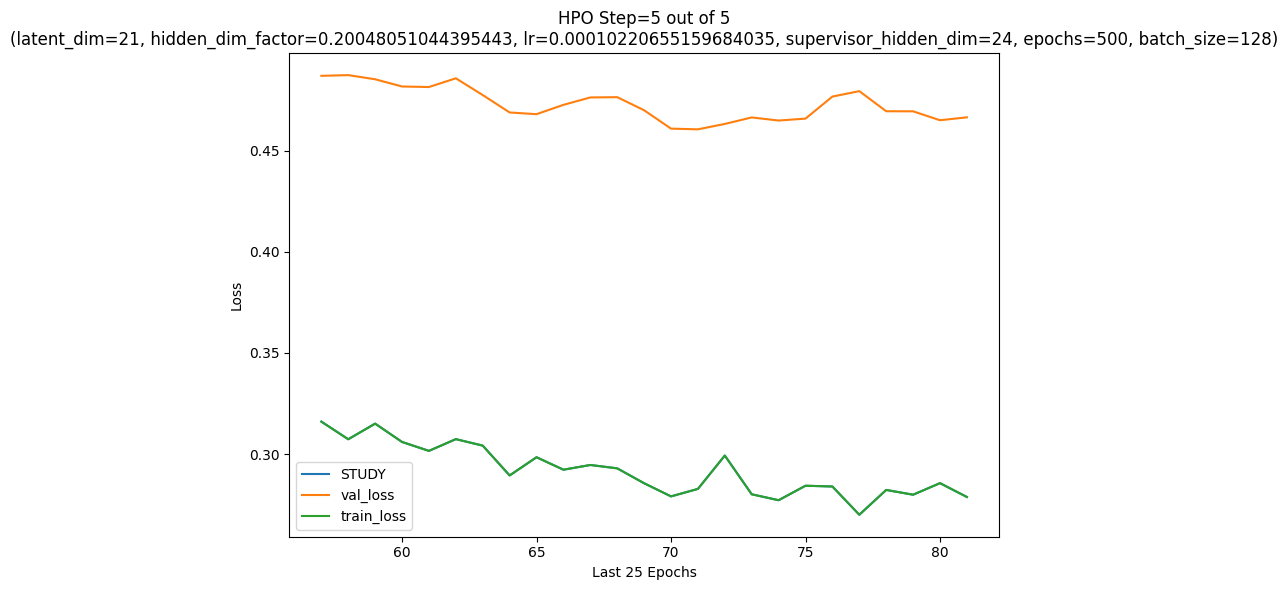

Validation: |                                                                                                 …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           STUDY           │    0.4665136933326721     │
│         val_loss          │    0.4665136933326721     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.61s/it, Iteration=5, Best Loss=0.325]

[INFO] current best val loss: 0.3252904415130615; best params: {'latent_dim': np.int64(21), 'hidden_dim_factor': 0.3112241358122884, 'lr': 0.0011249803898628523, 'supervisor_hidden_dim': np.int64(18), 'epochs': 500, 'batch_size': np.int64(64)} since 4 hpo iterations


In [33]:
# Define a tuner; See n_iter is the number of 
tuner = flexynesis.HyperparameterTuning(train_dataset, 
                                        model_class = flexynesis.DirectPred, 
                                        config_name = "DirectPred",
                                        target_variables = ['STUDY'], 
                                        n_iter=5, 
                                        plot_losses=True, 
                                        early_stop_patience=10)
### Perform Training 
model, best_params = tuner.perform_tuning()

In [34]:
## See which hyperparameter combination was the best 
best_params

{'latent_dim': np.int64(21),
 'hidden_dim_factor': 0.3112241358122884,
 'lr': 0.0011249803898628523,
 'supervisor_hidden_dim': np.int64(18),
 'epochs': 25,
 'batch_size': np.int64(64)}

In [35]:
## Evaluate the model and visualising the results
flexynesis.evaluate_wrapper(method = 'DirectPred', y_pred_dict=model.predict(test_dataset), dataset = test_dataset)                            

,method,var,variable_type,metric,value
0,DirectPred,STUDY,categorical,balanced_acc,0.779085
1,DirectPred,STUDY,categorical,f1_score,0.791396
2,DirectPred,STUDY,categorical,kappa,0.549550
3,DirectPred,STUDY,categorical,average_auroc,0.878431
4,DirectPred,STUDY,categorical,average_aupr,0.792359


Let's extract the sample embeddings and make a PCA plot and color by the target variable 

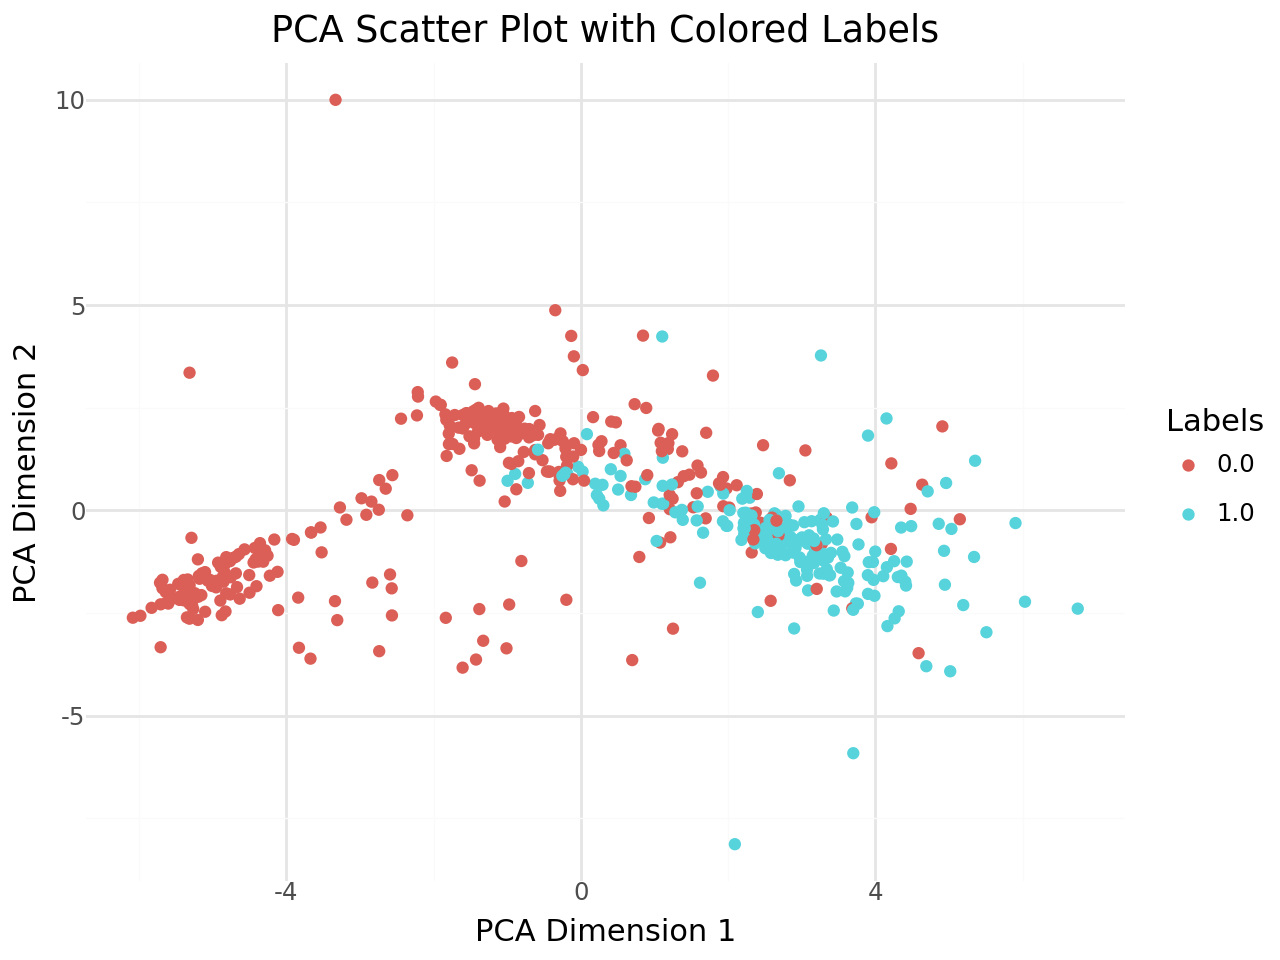

In [36]:
train_embeddings = model.transform(train_dataset)
flexynesis.plot_dim_reduced(train_embeddings, train_dataset.ann['STUDY'])

Repeat the same for the test dataset: extract sample embeddings for test dataset samples and make a PCA plot, colored by "STUDY" variable 

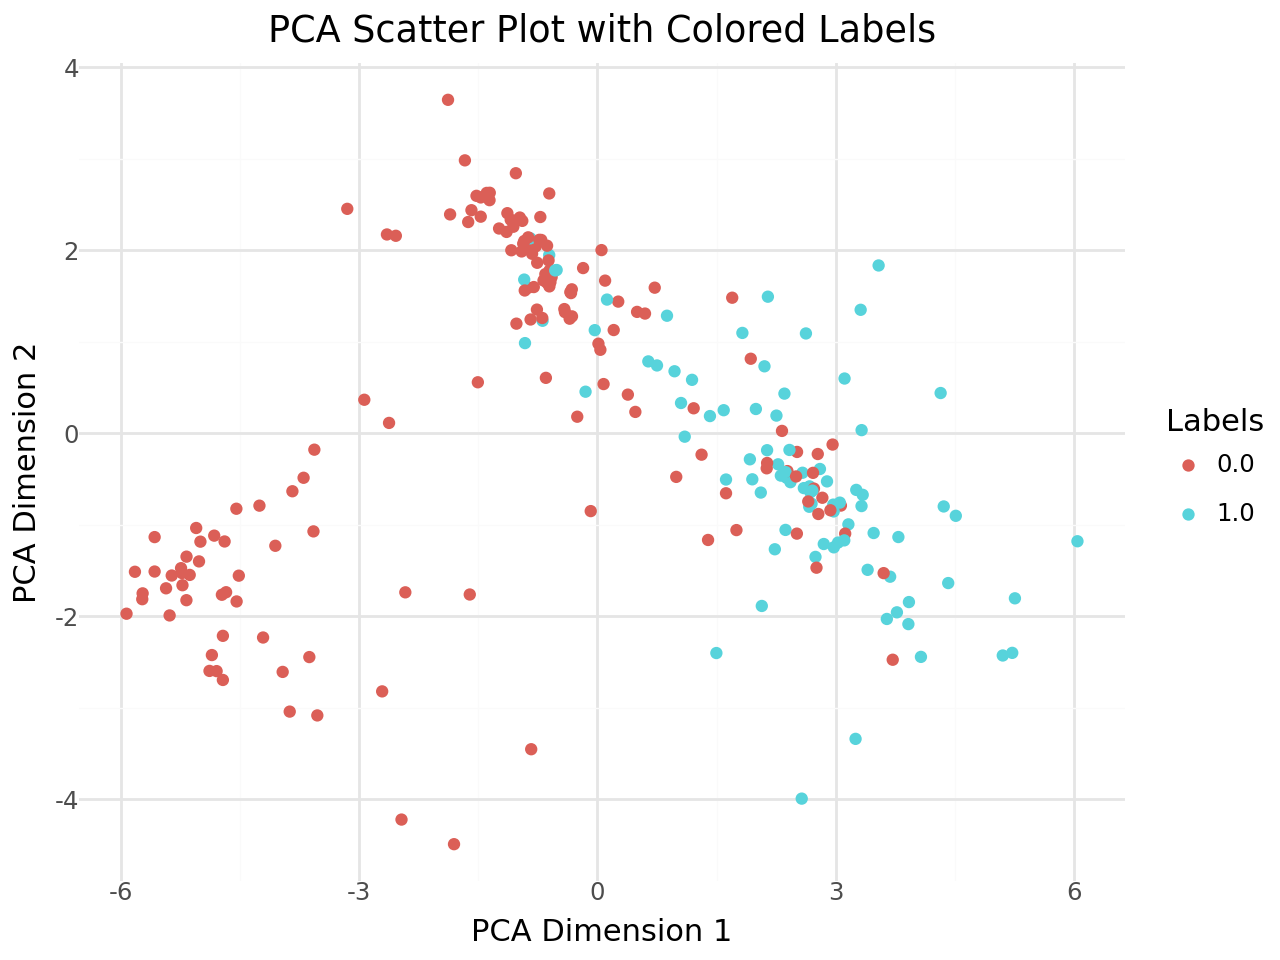

In [37]:
test_embeddings = model.transform(test_dataset)
flexynesis.plot_dim_reduced(test_embeddings, test_dataset.ann['STUDY'])

## 3.1 Exercises


**Exercise 1**: 

Look up what Harrell's C-index means and write down a simple description of what it measures. 

Harrell's C-index is a metric used to evaluate the performance of survival models, similar in spirit to the area under the ROC curve.

It measures how well the model can correctly rank individuals based on their predicted risk or survival times. In simple terms, a high C-index indicates that, in most pairs of patients, the one predicted to have a higher risk (or shorter survival) indeed experiences the event (e.g., death) before the other. 



**Exercise 2**:

Now, you build a model using hyperparameter tuning (run at least 10 HPO steps) to predict the survival outcomes of patients. 
Evaluate the final model on test dataset, which computes the "C-index". 

Feel free to cheat from the tutorial available here: https://github.com/BIMSBbioinfo/flexynesis/blob/main/examples/tutorials/survival_subtypes_LGG_GBM.ipynb
See how "OS_STATUS" and "OS_MONTHS" were used. 

In [38]:
HPO_ITER = 10

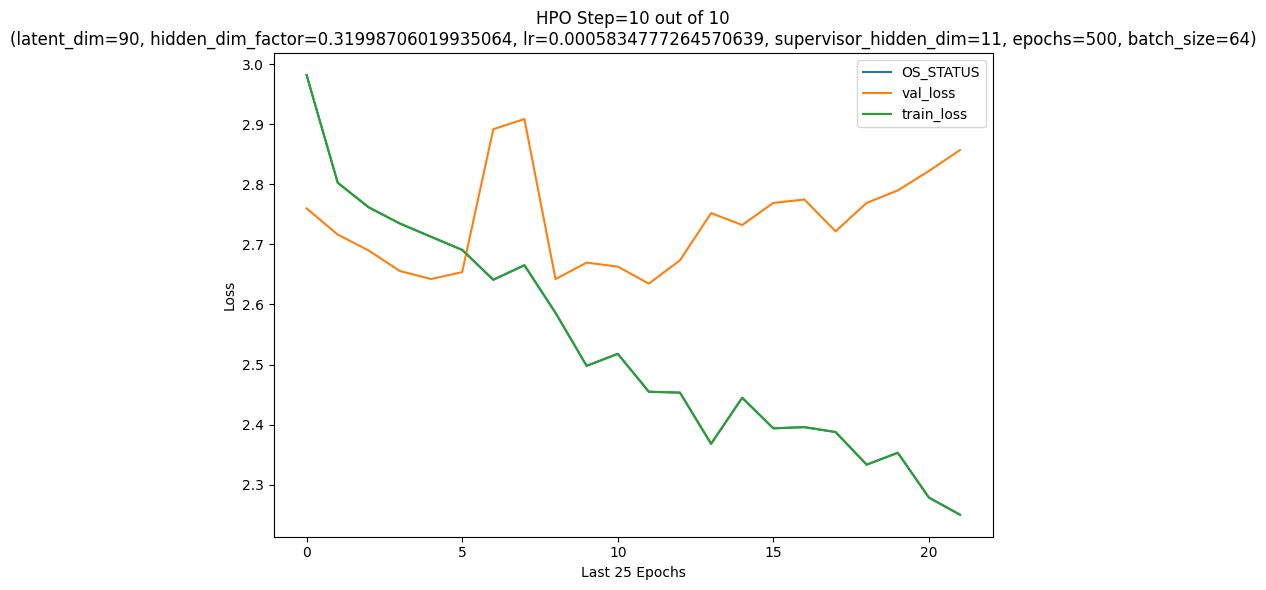

Validation: |                                                                                                 …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         OS_STATUS         │     2.85718201754386      │
│         val_loss          │     2.85718201754386      │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:17<00:00, 13.76s/it, Iteration=10, Best Loss=2.07]

[INFO] current best val loss: 2.068581081081081; best params: {'latent_dim': np.int64(84), 'hidden_dim_factor': 0.2997101430195794, 'lr': 0.0007571604525016091, 'supervisor_hidden_dim': np.int64(28), 'epochs': 500, 'batch_size': np.int64(32)} since 8 hpo iterations


In [39]:
tuner = flexynesis.HyperparameterTuning(train_dataset, 
                                        model_class = flexynesis.DirectPred, 
                                        config_name = "DirectPred",
                                        surv_event_var="OS_STATUS",
                                        surv_time_var="OS_MONTHS",
                                        target_variables = [], 
                                        n_iter=HPO_ITER, 
                                        plot_losses=True, 
                                        early_stop_patience=10)
model, best_params = tuner.perform_tuning()

In [40]:
best_params

{'latent_dim': np.int64(84),
 'hidden_dim_factor': 0.2997101430195794,
 'lr': 0.0007571604525016091,
 'supervisor_hidden_dim': np.int64(28),
 'epochs': 11,
 'batch_size': np.int64(32)}

In [41]:
flexynesis.evaluate_wrapper(method = 'DirectPred', y_pred_dict=model.predict(test_dataset), dataset = test_dataset, 
                            surv_event_var=model.surv_event_var, surv_time_var=model.surv_time_var)

,method,var,variable_type,metric,value
0,DirectPred,OS_STATUS,numerical,cindex,0.719466


**Exercise 3:**

Again build a model using hyperparameter tuning to predict survival outcomes (as in Exercise 1), however, this time use additional clinical variables as targets. 


    flexynesis.HyperparameterTuning(train_dataset, 
                                    model_class = flexynesis.DirectPred, 
                                    config_name = "DirectPred",
                                    surv_event_var="OS_STATUS",
                                    surv_time_var="OS_MONTHS",
                                    target_variables = [], => What other variables can you use here? Try "AGE" and/or "HISTOLOGICAL_DIAGNOSIS" and see the model performance 
                                    ...
                                    

**See if you can get a better C-index using additional target variables.**

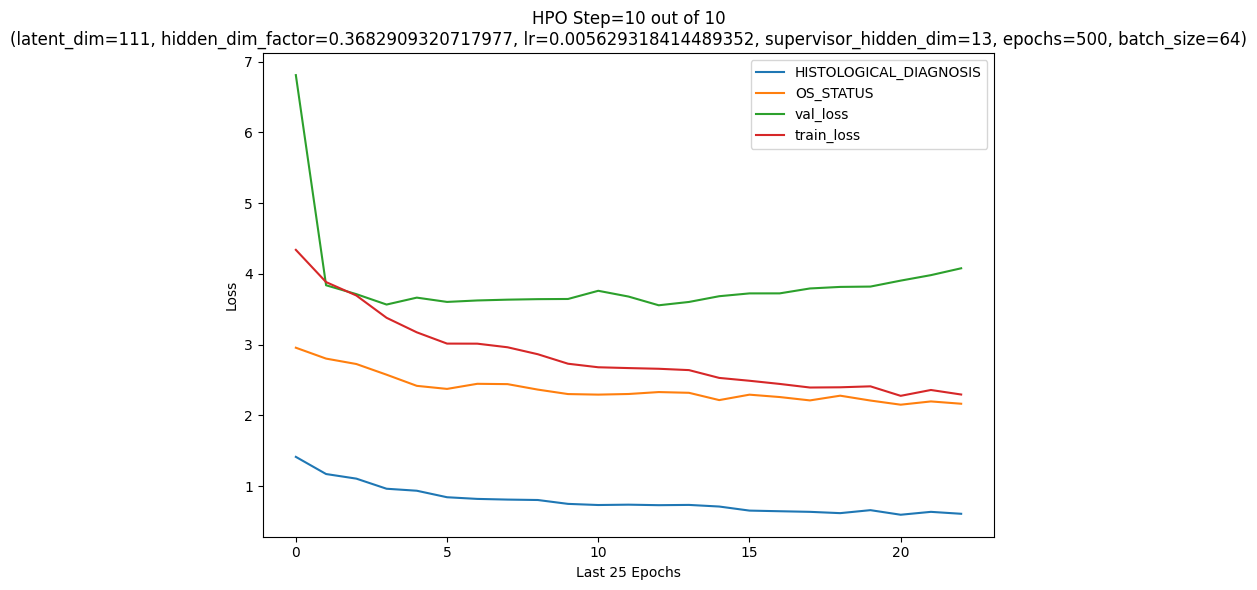

Validation: |                                                                                                 …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  HISTOLOGICAL_DIAGNOSIS   │    1.3720170259475708     │
│         OS_STATUS         │    2.7072715572715573     │
│         val_loss          │     4.079288554222274     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [05:57<00:00, 35.79s/it, Iteration=10, Best Loss=3.59]

[INFO] current best val loss: 3.594348140051313; best params: {'latent_dim': np.int64(96), 'hidden_dim_factor': 0.27865502422465854, 'lr': 0.0009938658038225435, 'supervisor_hidden_dim': np.int64(24), 'epochs': 500, 'batch_size': np.int64(64)} since 3 hpo iterations


In [42]:
tuner = flexynesis.HyperparameterTuning(train_dataset, 
                                        model_class = flexynesis.DirectPred, 
                                        config_name = "DirectPred",
                                        surv_event_var="OS_STATUS",
                                        surv_time_var="OS_MONTHS",
                                        target_variables = ["HISTOLOGICAL_DIAGNOSIS"], 
                                        n_iter=HPO_ITER, 
                                        plot_losses=True, 
                                        early_stop_patience=10)
model_histo, best_params_histo = tuner.perform_tuning()

In [43]:
best_params_histo

{'latent_dim': np.int64(96),
 'hidden_dim_factor': 0.27865502422465854,
 'lr': 0.0009938658038225435,
 'supervisor_hidden_dim': np.int64(24),
 'epochs': 20,
 'batch_size': np.int64(64)}

In [44]:
flexynesis.evaluate_wrapper(method = 'DirectPred', y_pred_dict=model_histo.predict(test_dataset), dataset = test_dataset, 
                            surv_event_var=model_histo.surv_event_var, surv_time_var=model_histo.surv_time_var)

,method,var,variable_type,metric,value
0,DirectPred,HISTOLOGICAL_DIAGNOSIS,categorical,balanced_acc,0.517421
1,DirectPred,HISTOLOGICAL_DIAGNOSIS,categorical,f1_score,0.559398
2,DirectPred,HISTOLOGICAL_DIAGNOSIS,categorical,kappa,0.395762
3,DirectPred,HISTOLOGICAL_DIAGNOSIS,categorical,average_auroc,NaN
4,DirectPred,HISTOLOGICAL_DIAGNOSIS,categorical,average_aupr,NaN
5,DirectPred,OS_STATUS,numerical,cindex,0.730734


In [ ]:
tuner = flexynesis.HyperparameterTuning(train_dataset, 
                                        model_class = flexynesis.DirectPred, 
                                        config_name = "DirectPred",
                                        surv_event_var="OS_STATUS",
                                        surv_time_var="OS_MONTHS",
                                        target_variables = ["HISTOLOGICAL_DIAGNOSIS"], 
                                        n_iter=HPO_ITER, 
                                        plot_losses=True, 
                                        early_stop_patience=10)
model_histo, best_params_histo = tuner.perform_tuning()

,latent_dim,hidden_dim_factor,lr,supervisor_hidden_dim,epochs,batch_size
Model Name,,,,,,
AGE,57,0.297327,0.004124,14,41,32
KARNOFSKY_PERFORMANCE_SCORE,43,0.415413,0.009521,8,32,32
STUDY,126,0.315875,0.000129,12,32,32
BCR_STATUS,80,0.359499,0.000431,30,31,32
HISTOLOGICAL_DIAGNOSIS,70,0.487421,0.000749,31,19,32
SEX,95,0.466202,0.000101,21,31,32
AGE + KARNOFSKY_PERFORMANCE_SCORE,117,0.357150,0.000788,31,121,32
AGE + STUDY,58,0.492938,0.008728,16,23,32
AGE + BCR_STATUS,27,0.215583,0.000928,28,90,32


<Figure size 1200x800 with 0 Axes>

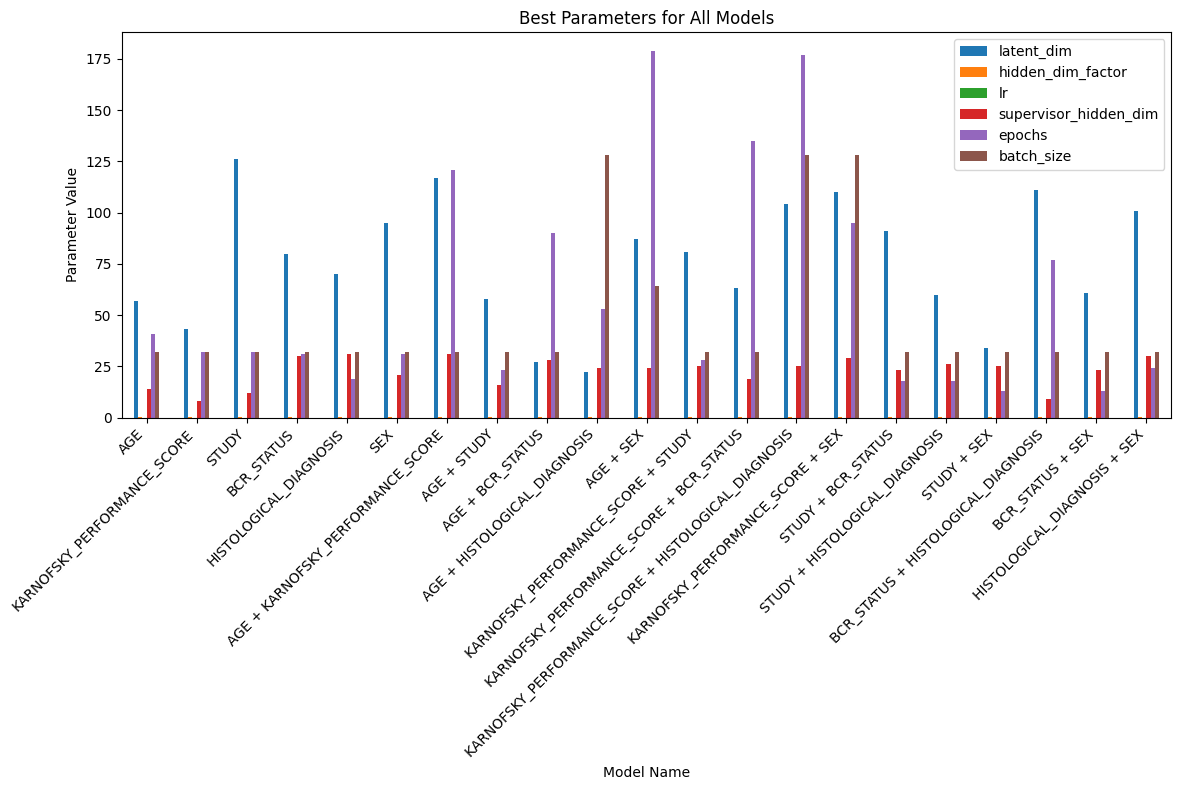

In [43]:
# Extract best parameters into a new DataFrame.
param_rows = []
for idx, row in results_df.iterrows():
    model_name = row["Model Name"]
    best_params = row["Best Parameters"]
    # Create a new row dictionary with the model name and its best parameters
    row_dict = {"Model Name": model_name}
    for param, value in best_params.items():
        row_dict[param] = value
    param_rows.append(row_dict)

params_df = pd.DataFrame(param_rows)
params_df = params_df.set_index("Model Name")
display(params_df)

# Visualize the best parameters for each model as a grouped bar chart.
# This assumes that all models share the same set of hyperparameter keys.
plt.figure(figsize=(12, 8))
params_df.plot(kind="bar", figsize=(12, 8))
plt.title("Best Parameters for All Models")
plt.xlabel("Model Name")
plt.ylabel("Parameter Value")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [67]:
evaluation_results = []

# Loop over the rows in results_df, each containing a Model Name and Best Parameters
for idx, row in results_df.iterrows():
    model_name = row["Model Name"]
    myparams = row["Best Parameters"]  # a dictionary of hyperparameter values
    target_vars = model_name.split(" + ")  # reconstruct the target variables from the string

    print(f"Re-building model '{model_name}' with best parameters: {myparams}")

    # Manually instantiate a DirectPred model with the best parameters
    direct_pred_model = flexynesis.DirectPred(
        config=myparams,         # Pass the dictionary of best hyperparams
        dataset=train_dataset,
        target_variables=target_vars,
        surv_event_var="OS_STATUS",
        surv_time_var="OS_MONTHS",
        n_iter=1,                # We already have the best params, so only 1 iteration is needed
        plot_losses=True,
        early_stop_patience=10
    )

    # Create a HyperparameterTuning object, but we won't search new params; we pass the existing model.
    tuner = flexynesis.HyperparameterTuning(
        train_dataset,
        model_class=flexynesis.DirectPred,
        config_name="DirectPred",
        surv_event_var="OS_STATUS",
        surv_time_var="OS_MONTHS",
        target_variables=target_vars,
        n_iter=1,                # Again, just 1 iteration to finalize training
        plot_losses=False,
        early_stop_patience=10
    )

    # Override tuner's model with our manually configured DirectPred
    tuner.model = direct_pred_model

    # Train the model with the provided best parameters (no further hyperparameter search)
    model_trained, best_params_final = tuner.perform_tuning()

    # Evaluate the model on the test dataset
    performance = flexynesis.evaluate_wrapper(
        method='DirectPred',
        y_pred_dict=model_trained.predict(test_dataset),
        dataset=test_dataset,
        surv_event_var=model_trained.surv_event_var,
        surv_time_var=model_trained.surv_time_var
    )

    # Collect the performance results for later analysis
    evaluation_results.append({
        "Model Name": model_name,
        "Performance": performance
    })

# Convert the collected evaluation results into a DataFrame and display
eval_df = pd.DataFrame(evaluation_results)
display(eval_df)


Index(['Model Name', 'Best Parameters'], dtype='object')
AGE


In [72]:
for idx, row in results_df.iterrows():
    model_name = row["Model Name"]
    myparams = row["Best Parameters"]  # a dictionary of hyperparameter values
    target_vars = model_name.split(" + ")  # reconstruct the target variables from the string
print(target_vars)

['HISTOLOGICAL_DIAGNOSIS', 'SEX']


In [76]:
results_df.iterrows()
print(results_df.iterrows())

<generator object DataFrame.iterrows at 0x7678d8d52680>


## 3.2 Survival-risk subtypes 

Use the best model from the above exercises to inspect sample embeddings categorized by survival risk scores. 

Let's group the samples by predicted survival risk scores into 2 groups and visualize the sample embeddings colored by risk subtypes.

**Notice**: You can use the code-below to get survival risk groups, however, notice that you must have built a model with "OS_STATUS" already. 

In [68]:
# get model outputs for survival variable 
model = results_df["Model Name"].iloc[0]
outputs = model.predict(test_dataset)['OS_STATUS'].flatten() 
risk_scores = np.exp(outputs)
# Define quantile thresholds
quantiles = np.quantile(risk_scores, [0.5])
# Assign groups based on quantiles
groups = np.digitize(risk_scores, quantiles)

AttributeError: 'str' object has no attribute 'predict'

In [ ]:
# Extract sample embeddings 
E = model.transform(test_dataset)

In [ ]:
flexynesis.plot_dim_reduced(E, groups)

Let's also see the Kaplan Meier Curves of the risk subtypes

In [ ]:
# remove samples with NA values first 
durations = test_dataset.ann['OS_MONTHS']
events = test_dataset.ann['OS_STATUS']
valid_indices = ~torch.isnan(durations) & ~torch.isnan(events)

In [ ]:
flexynesis.plot_kaplan_meier_curves(durations[valid_indices], events[valid_indices], groups[valid_indices]) 

### Finding survival-associated markers 

We can also compute feature importance scores for prediction of overall survival. 

In [ ]:
model.compute_feature_importance(train_dataset, 'OS_STATUS')

In [ ]:
# get top 10 features 
flexynesis.get_important_features(model, var = 'OS_STATUS', top=10)

### Comparing top markers with clinical covariates 

Let's build a linear Cox-PH model including the top 5 markers and other clinical variables such as histological diagnosis, disease type (STUDY), age, and sex. 

In [ ]:
# define a data.frame with clinical covariates and top markers along with survival endpoints 
vars = ['AGE', 'SEX', 'HISTOLOGICAL_DIAGNOSIS', 'STUDY', 'OS_MONTHS', 'OS_STATUS']
# read clinical variables 
df_clin = pd.concat(
    [pd.DataFrame({x: train_dataset.ann[x] for x in vars}, index=train_dataset.samples),
     pd.DataFrame({x: test_dataset.ann[x] for x in vars}, index=test_dataset.samples)], 
    axis = 0)
# get top 5 survival markers and extract the input data for these markers for both training and test data
imp = flexynesis.get_important_features(model, var = 'OS_STATUS', top=5) 
df_imp = pd.concat([train_dataset.get_feature_subset(imp), test_dataset.get_feature_subset(imp)], axis=0)  

# combine markers with clinical variables
df = pd.concat([df_imp, df_clin], axis = 1)
# remove samples without survival endpoints
df = df[df['OS_STATUS'].notna()]
df

In [ ]:
# build a cox model
coxm = flexynesis.build_cox_model(df, 'OS_MONTHS', 'OS_STATUS')

In [ ]:
# visualize log-hazard ratios sorted by p-values
flexynesis.plot_hazard_ratios(coxm)

## 3.3 Final Exercise

- Inspect the top 10 markers from section 3.2 and see if they have been characterized in the literature as important markers for Glioma disease progression. 